# Von Karman Vortex Shedding at Re=100
By Alan Kaptanoglu and Jared Callaham

This example is based on the manifold model, POD-Galerkin models, and constrained SINDy models of the following papers:

1. Schlegel 2013. On long-term boundedness of Galerkin models
2. Noack, 2003. A hierarchy of low-dimensional models for the transient and post-transient cylinder wake.
3. Loiseau 2018 Constrained sparse Galerkin regression. and uses some of the constrained and advanced SINDy features illustrated in examples 7 and 8.
The goal of this example is to show a detailed comparison of Galerkin models for the Re=100 von Karman shedding, between a center manifold model, a number of calculated POD-Galerkin models, and unconstrained/constrained SINDy models.

### Setup

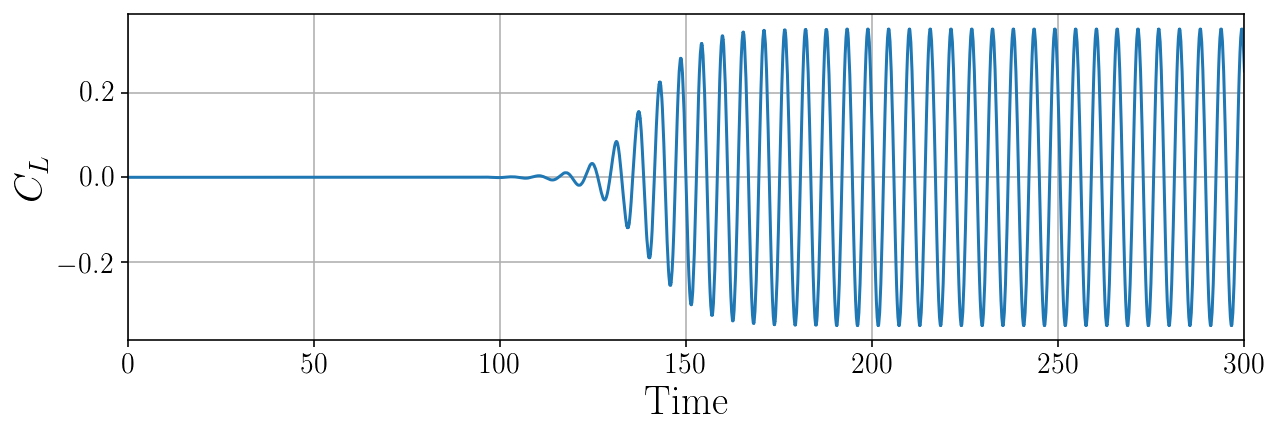

Strouhal number: 0.1800
Uncertainty +/- 0.0100
Approximate period: 5.5556


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.integrate import odeint
import pysindy as ps
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import complex_ode

mpl.rc('text', usetex=True)
mpl.rc('font', family='serif')
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', labelsize=20)
mpl.rc('axes', titlesize=20)
mpl.rc('figure', figsize=(12, 8))
%config InlineBackend.figure_format = 'retina'

mpl_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

galerkin = sio.loadmat('models/galerkin9.mat')
L = galerkin['L']
#with np.printoptions(precision=4, suppress=True):
#    print(L)
# Load aerodynamic moments
data = np.loadtxt('./forceCoeffs.dat', skiprows=1)
t_coeff = data[:, 0]
CD = data[:, 1]
CL = data[:, 2]

# Get rid of duplicates
t_coeff, idx = np.unique(t_coeff, return_index=True)
CD = CD[idx]
CL = CL[idx]

plt.figure(figsize=(10, 3))
plt.plot(t_coeff, CL, label='DNS')
plt.xlabel('Time')
plt.ylabel(r'$C_L$')
plt.grid()
plt.xlim([0, 300])
plt.show()
# Stabilizes after ~25000 time steps
dt = t_coeff[1]-t_coeff[0]
E = np.abs((dt*np.fft.fft(CL[t_coeff>200]))**2)
E = E[:int(len(E)/2)]
N = len(E)
freq = np.arange(N)/(2*dt*N)

St = freq[np.argmax(E)]
print('Strouhal number: {0:0.4f}'.format(St))
print('Uncertainty +/- {0:0.4f}'.format(freq[1]-freq[0]))

print('Approximate period: {0:0.4f}'.format(1/St))
#print(dt)

### POD-Galerkin models

(3000, 9)


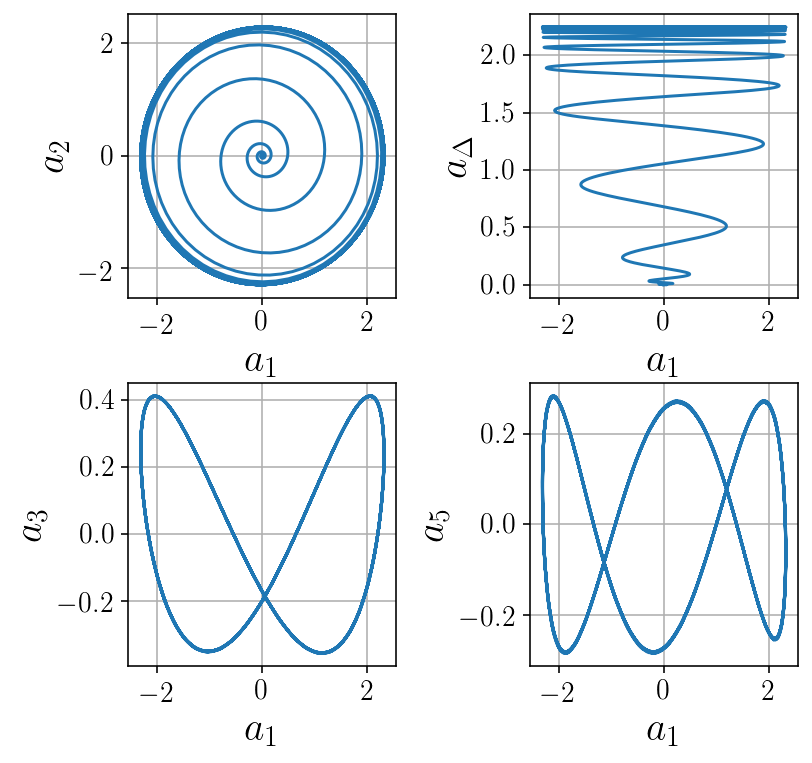

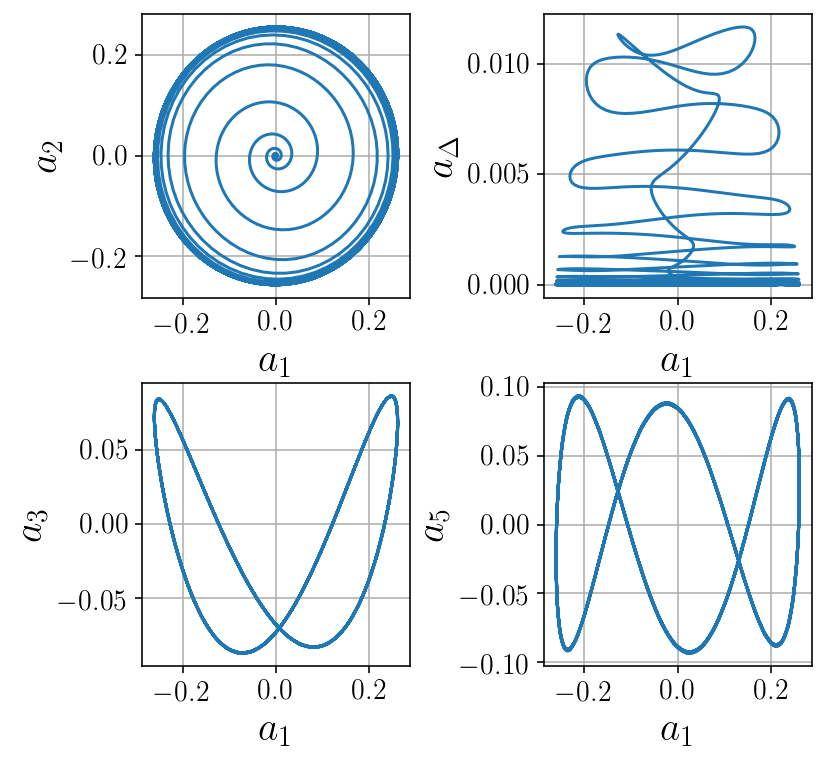

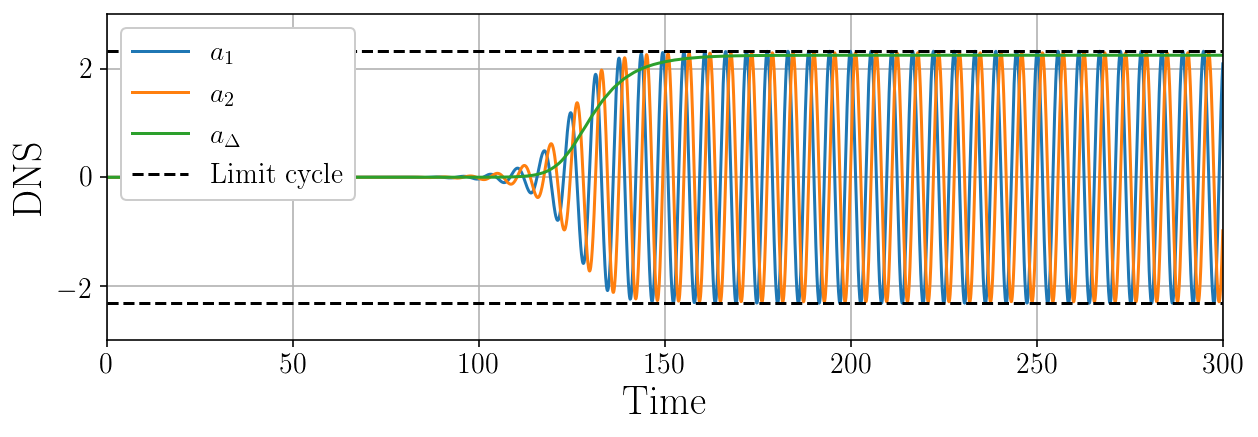

In [2]:
a = np.loadtxt('./a.dat')
t = a[:, 0]
a = a[:, 1:]
a_dot = np.zeros(a.shape)
for i in range(a.shape[1]):
    a_dot[:, i] = np.asarray(np.gradient(a[:, i]))
print(a_dot.shape)
a_max = max(a[:, :2].flatten())

t_steady = 250

plt.figure(figsize=(6, 6))
plt.subplot(221)
plt.plot(a[:, 0], a[:, 1])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_2$')
plt.grid()

plt.subplot(222)
plt.plot(a[:, 0], a[:, -1])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_\Delta$')
plt.grid()

plt.subplot(223)
plt.plot(a[t>t_steady, 0], a[t>t_steady, 2])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_3$')
plt.grid()

plt.subplot(224)
plt.plot(a[t>t_steady, 0], a[t>t_steady, 4])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_5$')
plt.grid()

plt.subplots_adjust(wspace=0.5, hspace=0.3)

plt.figure(figsize=(6, 6))
plt.subplot(221)
plt.plot(a_dot[:, 0], a_dot[:, 1])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_2$')
plt.grid()

plt.subplot(222)
plt.plot(a_dot[:, 0], a_dot[:, -1])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_\Delta$')
plt.grid()

plt.subplot(223)
plt.plot(a_dot[t>t_steady, 0], a_dot[t>t_steady, 2])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_3$')
plt.grid()

plt.subplot(224)
plt.plot(a_dot[t>t_steady, 0], a_dot[t>t_steady, 4])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_5$')
plt.grid()

plt.subplots_adjust(wspace=0.5, hspace=0.3)

a_max = max(abs(a[:, 0]))

plt.figure(figsize=(10, 3))
plt.plot(t, a[:, [0, 1, -1]])
plt.plot([t[0], t[-1]], [a_max, a_max], 'k--')
plt.plot([t[0], t[-1]], [-a_max, -a_max], 'k--')
plt.ylim([-3, 3])
plt.xlim([0, 300])
plt.ylabel('DNS')
plt.xlabel('Time')
plt.legend(['$a_1$', '$a_2$', r'$a_\Delta$', 'Limit cycle'],
           loc=2, fancybox=True, framealpha=1, fontsize=14)
plt.grid()

#plt.savefig(fig_dir+'deane_model.svg')
plt.show()


### Compare 3-mode (shift-mode) POD-Galerkin model with DNS

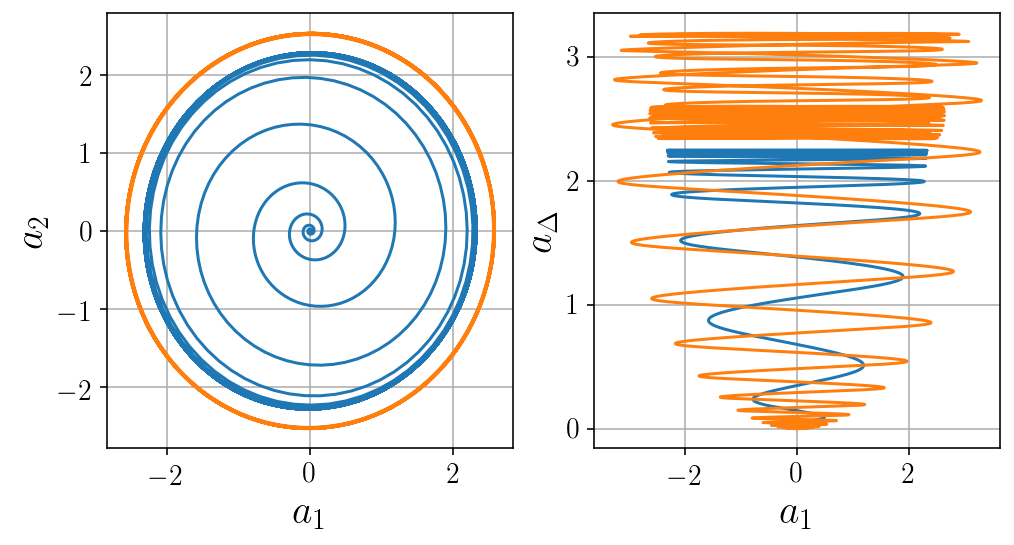

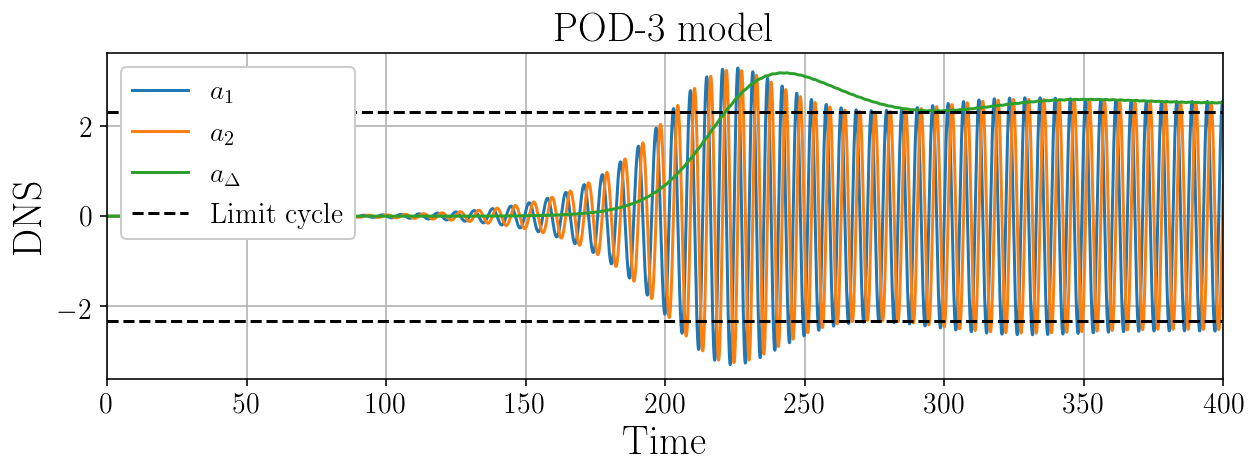

In [3]:
def pg_model(a, L, Q):
    """RHS of POD-Galerkin model, for time integration"""
    return (L @ a) + np.einsum('ijk,j,k->i', Q, a, a)

galerkin3 = sio.loadmat('models/galerkin3.mat')
model3 = lambda a, t: pg_model(a, galerkin3['L'], galerkin3['Q'])

galerkin9 = sio.loadmat('models/galerkin9.mat')
model9 = lambda a, t: pg_model(a, galerkin9['L'], galerkin9['Q'])

# Simulate Galerkin models
t_sim = np.arange(0, 500, dt)

# Generate initial condition from unstable eigenvectors
lamb, Phi = np.linalg.eig(galerkin9['L'])
idx = np.argsort(-np.real(lamb))
lamb, Phi = lamb[idx], Phi[:, idx]
a0 = np.real( 1e-3*Phi[:, :2] @ np.random.random((2)) )

a_galerkin3 = odeint(model3, a0[:3], t_sim)
a_galerkin9 = odeint(model9, a0[:9], t_sim)
# Plot Galerkin-3 results
t_steady_sim = 400

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.plot(a[:, 0], a[:, 1])
plt.plot(a_galerkin3[t_sim>t_steady_sim, 0], a_galerkin3[t_sim>t_steady_sim, 1])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_2$')
plt.grid()

plt.subplot(122)
plt.plot(a[:, 0], a[:, -1])
plt.plot(a_galerkin3[:, 0], a_galerkin3[:, -1])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_\Delta$')
plt.grid()
plt.figure(figsize=(10, 3))
plt.plot(t_sim, a_galerkin3[:, [0, 1, -1]])
plt.plot([t_sim[0], t_sim[-1]], [a_max, a_max], 'k--')
plt.plot([t_sim[0], t_sim[-1]], [-a_max, -a_max], 'k--')
plt.xlim([0, 400])
plt.ylabel('DNS')
plt.xlabel('Time')
plt.legend(['$a_1$', '$a_2$', r'$a_\Delta$', 'Limit cycle'],
           loc=2, fancybox=True, framealpha=1, fontsize=14)
plt.grid()
plt.title("POD-3 model")

plt.show()

### Compare 9-mode (shift-mode) POD-Galerkin model with DNS

[[1.2030129e-07 4.1603837e-08 2.3466293e-09]
 [2.3466293e-09 4.1603837e-08 1.2030129e-07]
 [5.8910005e-02 3.8263455e-03 1.3287652e-04]
 [1.3287652e-04 3.8263455e-03 5.8910005e-02]
 [8.8669622e-04 7.8507870e-01 8.8669622e-04]
 [1.1483223e-05 6.0974548e-07 1.8397255e-07]
 [1.8397255e-07 6.0974548e-07 1.1483223e-05]
 [6.6886016e-04 1.7040549e-04 2.2871853e-05]
 [2.2871853e-05 1.7040549e-04 6.6886016e-04]]


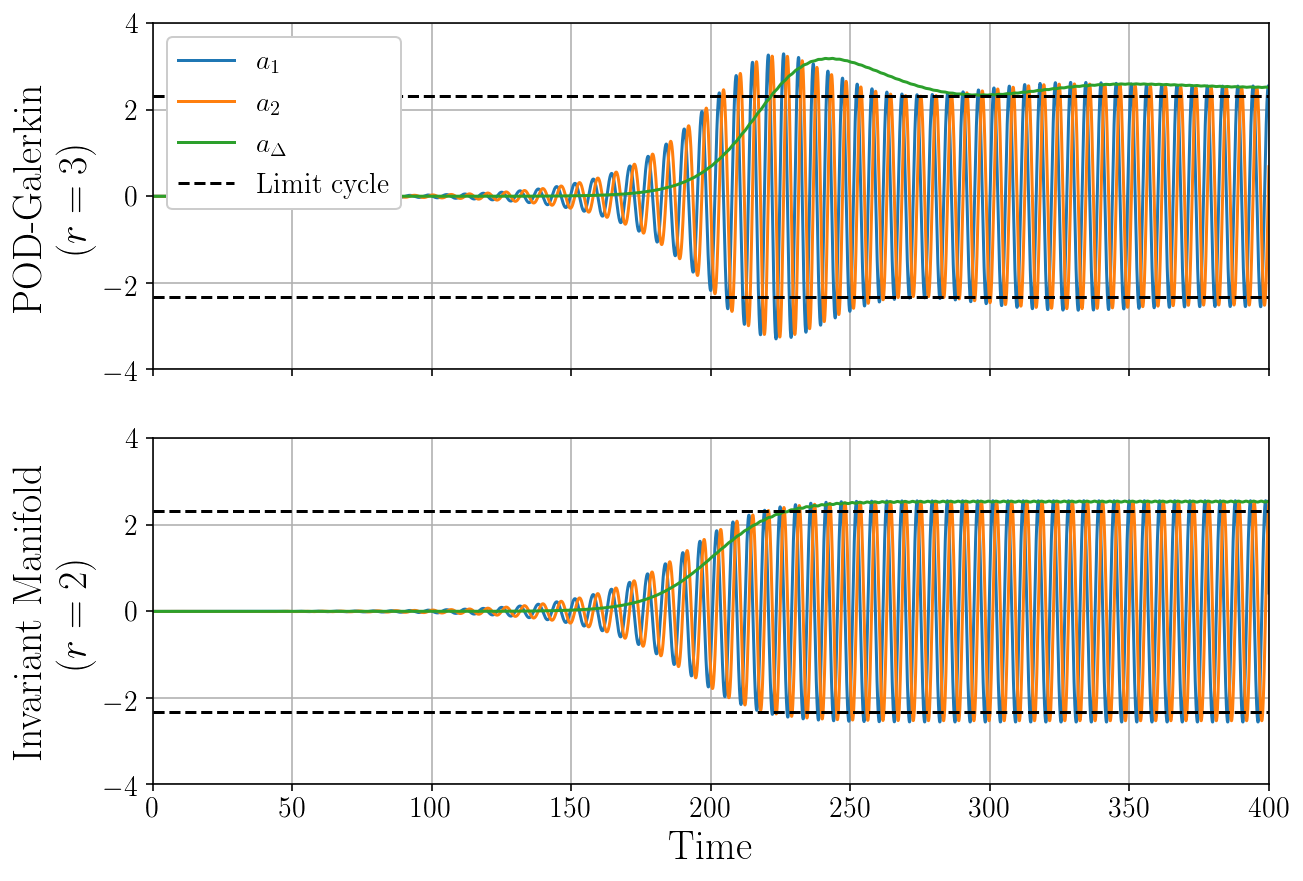

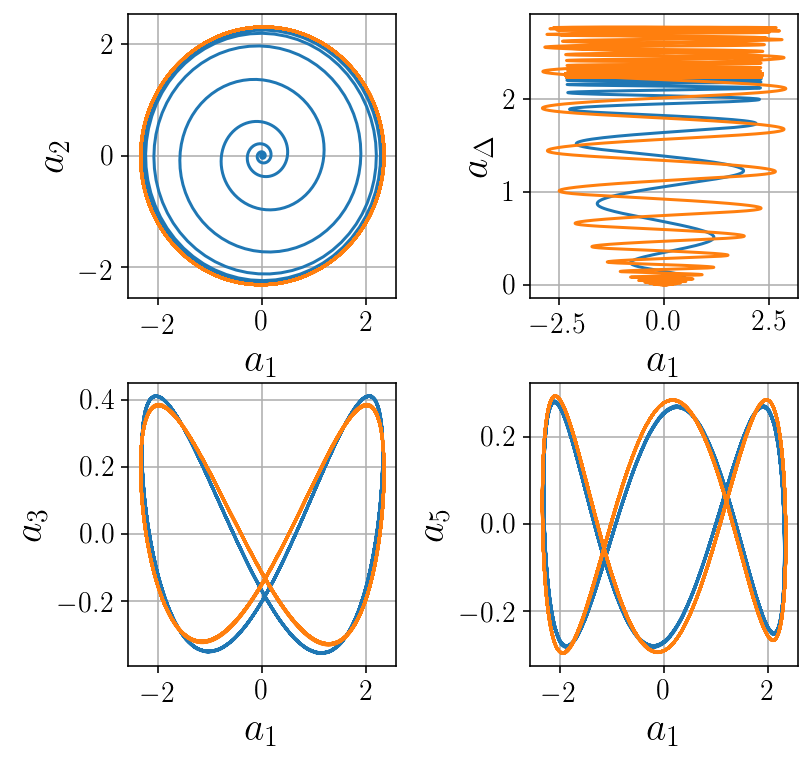

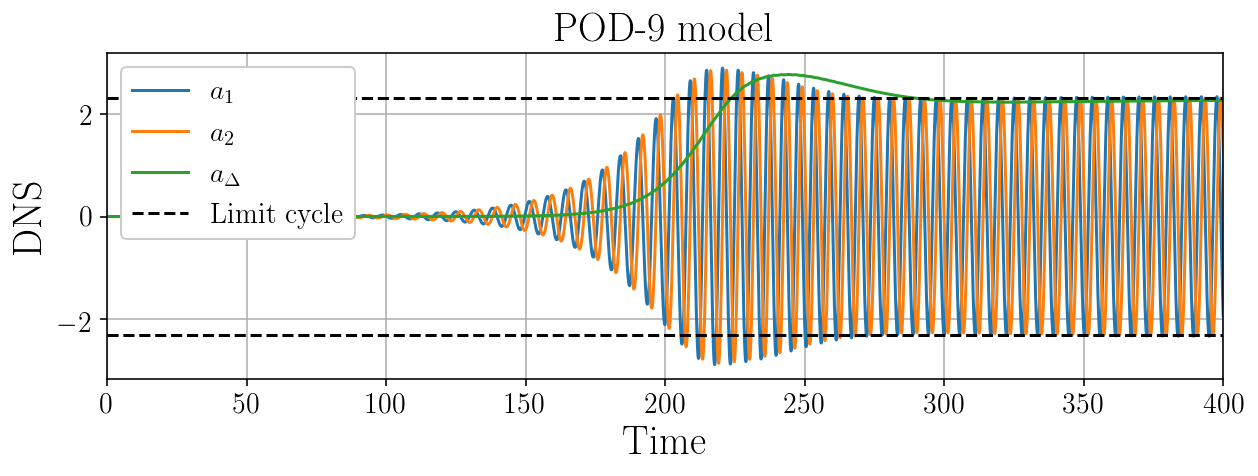

In [4]:
r = 9
L = galerkin9['L']
Q = galerkin9['Q']

# Eigendecomposition of linear part of Galerkin model
evals, Phi = np.linalg.eig(L)

# Order by real part, so unstable evals are first
sort_idx = np.argsort(-np.real(evals))
evals = evals[sort_idx]
Phi = Phi[:, sort_idx]
Phi_inv = np.linalg.inv(Phi)

L_nf = Phi_inv @ L @ Phi
Q_nf = np.einsum('nlm,in,lj,mk->ijk', Q, Phi_inv, Phi, Phi)

model_nf = lambda t, b: pg_model(b, L_nf, Q_nf)

# Don't need to re-center on fixed point since we expanded around the steady state
#  (Otherwise this would be a0 - a_s)
b0 = Phi_inv @ a0[:r]

# Assume that the eigendecomposition actually did
#    diagonalize the upper block of the "normal form"
L11 = 1j*np.imag(L_nf[0, 0])
L22 = 1j*np.imag(L_nf[1, 1])

#L11 = L_nf[0, 0]
#L22 = L_nf[1, 1]

# Build the big matrix for the linear algebra problem
L_mat = np.zeros((3*r, 3*r), dtype='complex64')
L_mat[:r, :r] = 2*L11*np.eye(r) - L_nf
L_mat[r:-r, r:-r] = (L11+L22)*np.eye(r) - L_nf
L_mat[-r:,-r:] = 2*L22*np.eye(r) - L_nf

q_vec = np.zeros((3*r), dtype='complex64')
q_vec[:r] = Q_nf[:, 0, 0]
q_vec[r:-r] = Q_nf[:, 0, 1] + Q_nf[:, 1, 0]
q_vec[-r:] = Q_nf[:, 1, 1]

h_vec = np.linalg.inv(L_mat) @ q_vec
H = np.zeros((r, 3), dtype='complex64')
H[:, 0] = h_vec[:r]
H[:, 1] = h_vec[r:-r]
H[:, 2] = h_vec[-r:]

# Print analytic manifold equation
print(abs(H))

# Create a function for the manifold model (assuming leading two coordinates are driving)
order = 2
def manifold_eq(b, H, order):
    # 2D Polynomial library
    lib = np.array([b[0]**(i-j)*b[1]**j for i in range(2, order+1) for j in range(i+1)])
    b_poly = H @ lib  # Manifold equation
    b_poly[:2] = b[:2]  # Leave active coordinates unchanged
    return b_poly

def dae_model(b, L, Q, H, order):
    # Slave coordinates to the manifold and then evolve with the full model
    b_full = manifold_eq(b, H, order)
    db = pg_model(b_full, L, Q)
    return db[:2]

model = lambda t, b: dae_model(b, L_nf, Q_nf, H, order)

#b0 = Phi_inv @ (a0 - a_s)

b0_manifold = b0[:2]
integrator = complex_ode(model)
integrator.set_initial_value(b0_manifold, 0)

b_manifold = np.zeros((2, len(t_sim)), dtype='complex64')
idx = 0
while integrator.successful() and idx<len(t_sim)-1:
    idx+=1
    integrator.integrate(integrator.t+dt)
    b_manifold[:, idx] = integrator.y

#b_galerkin = odeint(model_nf, b0, t_sim)
b_full = np.zeros((r, len(t_sim)), dtype='complex64')
b_full[:2, :] = b_manifold
for i in range(len(t_sim)):
    b_full[:, i] = manifold_eq(b_manifold[:, i], H, order)  # Recover other variables
    
a_manifold = np.real( Phi @ b_full )

plt.figure(figsize=(10, 7))
plt.subplot(211)
#plt.plot(t_sim, a_galerkin[[0, 1, -1], :].T)
plt.plot(t_sim, a_galerkin3)
plt.plot([t_sim[0], t_sim[-1]], [a_max, a_max], 'k--')
plt.plot([t_sim[0], t_sim[-1]], [-a_max, -a_max], 'k--')
plt.ylim([-4, 4])
plt.xlim([0, 400])
plt.legend(['$a_1$', '$a_2$', r'$a_\Delta$', 'Limit cycle'],
           loc=2, fancybox=True, framealpha=1, fontsize=14)
plt.ylabel('POD-Galerkin\n($r=3$)')
plt.grid()

plt.gca().set_xticklabels([])

plt.subplot(212)#plt.plot(t_sim, a_galerkin[[0, 1, -1], :len(t_sim)].T)
plt.plot(t_sim, a_manifold[[0, 1, -1], :].T)
plt.plot([t_sim[0], t_sim[-1]], [a_max, a_max], 'k--')
plt.plot([t_sim[0], t_sim[-1]], [-a_max, -a_max], 'k--')
plt.grid()
plt.ylabel('Invariant Manifold\n($r=2$)')
plt.ylim([-4, 4])
plt.xlim([0, 400])
plt.xlabel('Time')
plt.show()


# Plot Galerkin-9 results
plt.figure(figsize=(6, 6))
plt.subplot(221)
plt.plot(a[:, 0], a[:, 1])
plt.plot(a_galerkin9[t_sim>t_steady_sim, 0], a_galerkin9[t_sim>t_steady_sim, 1])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_2$')
plt.grid()

plt.subplot(222)
plt.plot(a[:, 0], a[:, -1])
plt.plot(a_galerkin9[:, 0], a_galerkin9[:, -1])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_\Delta$')
plt.grid()

plt.subplot(223)
plt.plot(a[t>t_steady, 0], a[t>t_steady, 2])
plt.plot(a_galerkin9[t_sim>t_steady_sim, 0], a_galerkin9[t_sim>t_steady_sim, 2])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_3$')
plt.grid()

plt.subplot(224)
plt.plot(a[t>t_steady, 0], a[t>t_steady, 4])
plt.plot(a_galerkin9[t_sim>t_steady_sim, 0], a_galerkin9[t_sim>t_steady_sim, 4])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_5$')
plt.grid()

plt.subplots_adjust(wspace=0.5, hspace=0.3)

plt.figure(figsize=(10, 3))
plt.plot(t_sim, a_galerkin9[:, [0, 1, -1]])
plt.plot([t_sim[0], t_sim[-1]], [a_max, a_max], 'k--')
plt.plot([t_sim[0], t_sim[-1]], [-a_max, -a_max], 'k--')
plt.xlim([0, 400])
plt.ylabel('DNS')
plt.xlabel('Time')
plt.legend(['$a_1$', '$a_2$', r'$a_\Delta$', 'Limit cycle'],
           loc=2, fancybox=True, framealpha=1, fontsize=14)
plt.grid()
plt.title("POD-9 model")

plt.show()

# Cubic SINDy model

x0' = 0.010 x0 + -0.863 x1 + -0.270 x1x2 + 0.063 x0x1 + 0.063 x1x1x1
x1' = 0.783 x0 + 0.151 x1 + 0.144 x0x2 + -0.072 x1x2
x2' = 0.188 x2 + -0.084 x2x2
[[ 0.00962854  0.7827964   0.        ]
 [-0.86349555  0.15087918  0.        ]
 [ 0.          0.          0.18800251]
 [ 0.          0.          0.        ]
 [ 0.          0.14433464  0.        ]
 [-0.27044114 -0.07209658  0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         -0.08397291]
 [ 0.          0.          0.        ]
 [ 0.06264369  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.06322984  0.          0.        ]
 [ 0.          0.          0.        ]]


/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


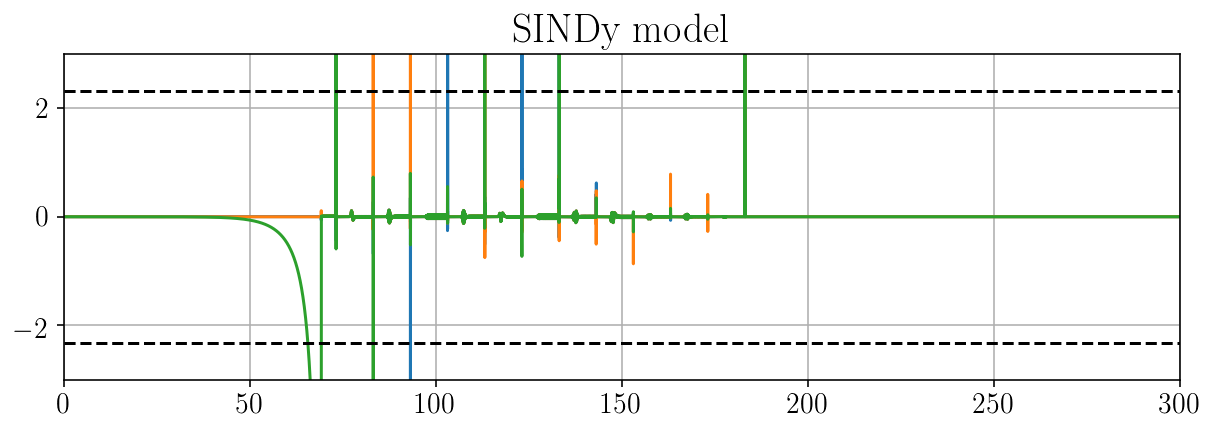

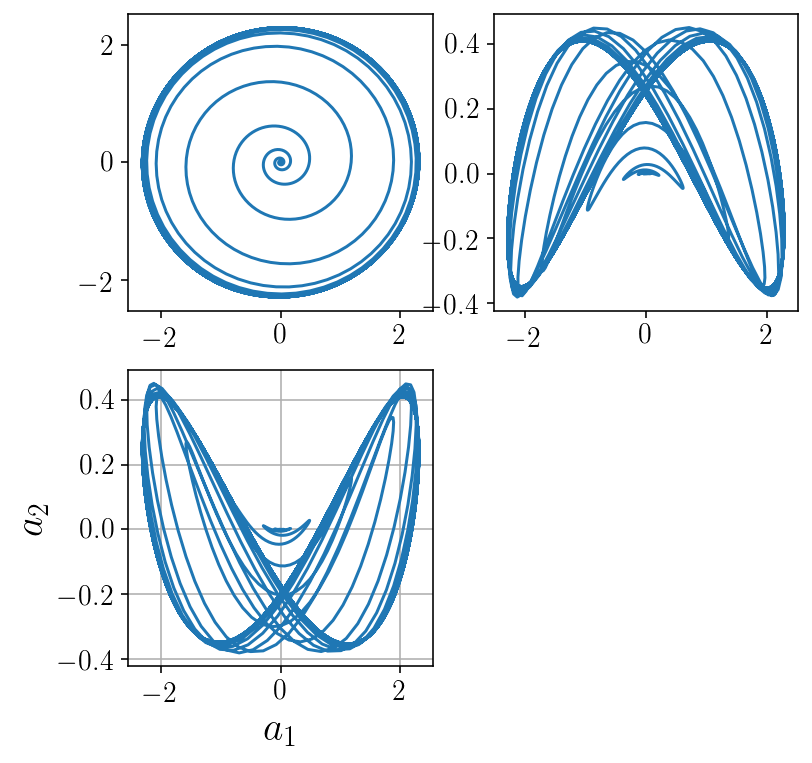

In [5]:
# Nonlinear correlations for POD reconstruction
steady_idx = t>250
threshold = 0.05
poly_order = 2
r = 3
a3 = a[:,[0, 1, -1]]
library_functions = [lambda x:x, lambda x, y:x*y, lambda x:x**2, 
                     lambda x, y, z:x*y*z, lambda x, y:x**2*y, lambda x:x**3]
library_function_names = [lambda x:x, lambda x, y:x+y, lambda x:x+x, 
                          lambda x, y, z:x+y+z, lambda x, y:x+y, lambda x:x+x+x]
sindy_library = ps.CustomLibrary(library_functions=library_functions,
                                 function_names=library_function_names)
sindy_opt = ps.ConstrainedSR3(threshold=threshold, nu=1.0, 
                              max_iter=2000, tol=1e-10,
                              thresholder="l0")
model = ps.SINDy(
            optimizer=sindy_opt,
            feature_library=sindy_library,
            differentiation_method=ps.FiniteDifference(drop_endpoints=True))
model.fit(a3, t=t)
model.print()
Xi = model.coefficients().T
print(Xi)
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-20
integrator_keywords['h0'] = 1e-5
a_sindy = model.simulate(a3[300,:], t_sim, integrator_kws=integrator_keywords)

plt.figure(figsize=(10, 3))
plt.plot(t_sim, a_sindy[:, [0, 1, -1]])
plt.plot([t_sim[0], t_sim[-1]], [a_max, a_max], 'k--')
plt.plot([t_sim[0], t_sim[-1]], [-a_max, -a_max], 'k--')
plt.ylim([-3, 3])
plt.xlim([0, 300])
plt.title('SINDy model')
plt.grid()


plt.figure(figsize=(6, 6))
plt.subplot(221)
plt.plot(a[:, 0], a[:, 1])
plt.subplot(222)
plt.plot(a[:, 1], a[:, 2])
plt.subplot(223)
plt.plot(a[:, 0], a[:, 2])
#plt.plot(a_sindy[:, 0], a_sindy[:, 1])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_2$')
plt.grid()
plt.show()

### Try 3-mode (shift-mode) constrained quadratic SINDy model

9 (10,) (10, 27)
x0' = 0.128 x0 + -0.808 x1 + -0.054 x0x2 + -0.146 x1x2
x1' = 0.778 x0 + 0.117 x1 + 0.147 x0x2 + -0.057 x1x2
x2' = -0.129 x2 + 0.054 x0x0 + 0.057 x1x1
[[ 0.1277462   0.77754171  0.        ]
 [-0.80768308  0.11732324  0.        ]
 [-0.         -0.         -0.1291644 ]
 [-0.         -0.         -0.        ]
 [-0.05401202  0.14675284 -0.        ]
 [-0.14600446 -0.05658975 -0.        ]
 [ 0.          0.          0.05401202]
 [ 0.         -0.          0.05658975]
 [ 0.          0.         -0.        ]]


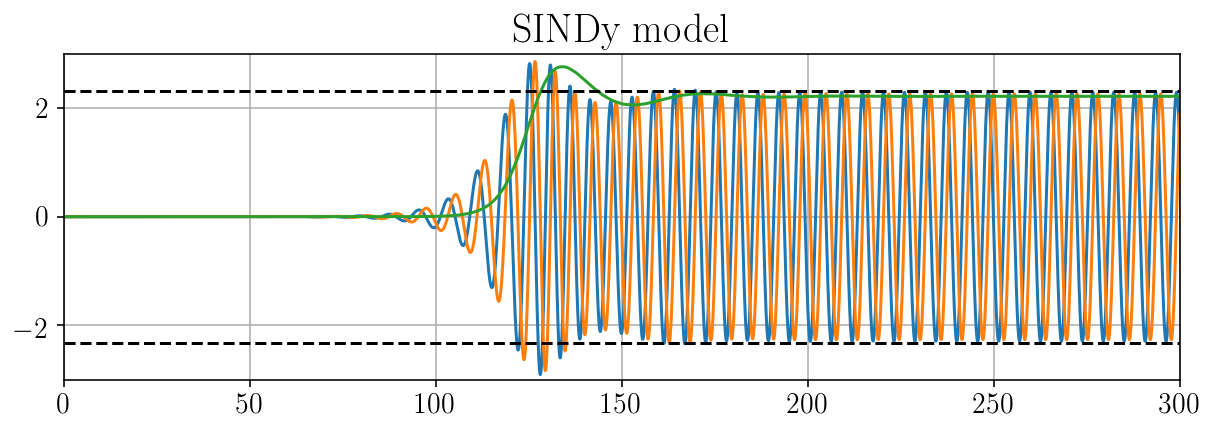

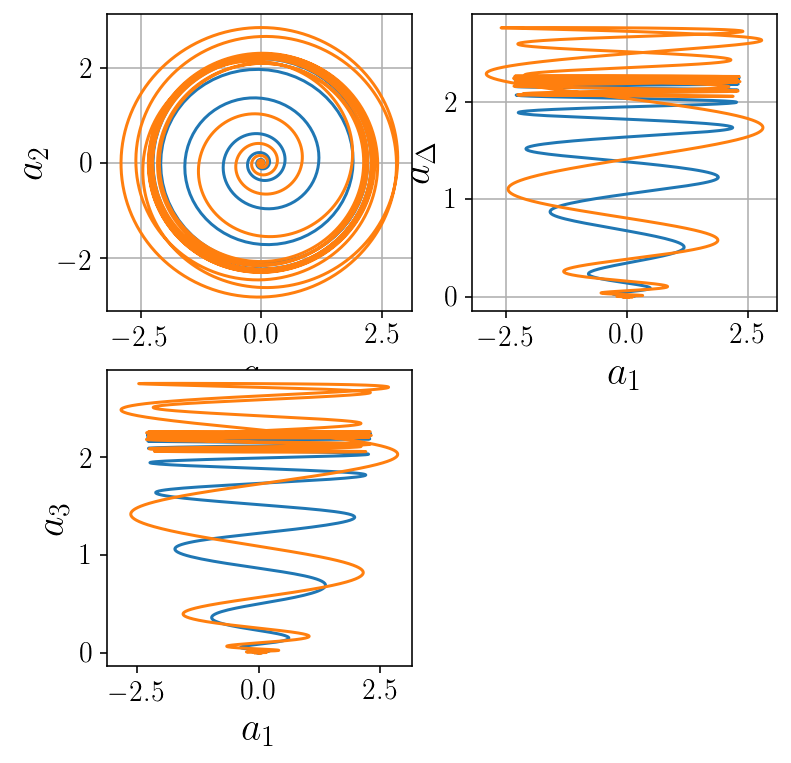

In [6]:
# Nonlinear correlations for POD reconstruction
steady_idx = t>250

## Setup hyperparameters and matrices
r = 3
Nr = int((r**2 + 3*r)/2.0)
q = 0
constraint_zeros = np.zeros((r + r*(r-1) + int(r*(r-1)*(r-2)/6.0)))
constraint_matrix = np.zeros((r + r*(r-1) + int(r*(r-1)*(r-2)/6.0), r * Nr))

# Set coefficients adorning terms like a_i^3 to zero
for i in range(r):
    constraint_matrix[q, r*(int((r**2+3*r)/2.0)-r) + i*(r+1)] = 1.0
    q = q + 1

# Set coefficients adorning terms like a_ia_j^2 to be antisymmetric
for i in range(r):
    for j in range(i+1, r):
        constraint_matrix[q, r*(int((r**2+3*r)/2.0)-r+j)+i] = 1.0
        constraint_matrix[q, r*(r+j-1)+j+r*int(i*(2*r-i-3)/2.0)] = 1.0
        q = q + 1
for i in range(r):
     for j in range(0, i):
        constraint_matrix[q, r*(int((r**2+3*r)/2.0)-r+j)+i] = 1.0
        constraint_matrix[q, r*(r+i-1)+j+r*int(j*(2*r-j-3)/2.0)] = 1.0
        q = q + 1

# Set coefficients adorning terms like a_ia_ja_k to be antisymmetric
for i in range(r):
    for j in range(i+1, r):
        for k in range(j+1, r):
            constraint_matrix[q, r*(r+k-1)+i+r*int(j*(2*r-j-3)/2.0)] = 1.0
            constraint_matrix[q, r*(r+k-1)+j+r*int(i*(2*r-i-3)/2.0)] = 1.0
            constraint_matrix[q, r*(r+j-1)+k+r*int(i*(2*r-i-3)/2.0)] = 1.0
            q = q + 1
# delta_{il}delta_{jk}
PL_tensor = np.zeros((r, r, r, Nr))
for i in range(r):
    for j in range(r):
        for k in range(r):
            for l in range(Nr):
                if i == l and j == k:
                    PL_tensor[i, j, k, l] = 1.0

# Now symmetrize PL
for i in range(r):
    for j in range(Nr):
        PL_tensor[:, :, i, j] = 0.5 * (PL_tensor[:, :, i, j] + PL_tensor[:, :, i, j].T)

PQ_tensor = np.zeros((r, r, Nr))
for i in range(r):
    # Off diagonal terms
    for j in range(i+1, r):
        PQ_tensor[i, j, int((i+1)/2.0*(2*r-i)) + j - 1 - i] = 1.0

    # diagonal terms
    PQ_tensor[i, i, Nr - r + i] = 1.0

# Now symmetrize PQ
for j in range(Nr):
    PQ_tensor[:, :, j] = 0.5 * (PQ_tensor[:, :, j] + PQ_tensor[:, :, j].T)
    
    
threshold = 0.001
poly_order = 2
print(Nr, constraint_zeros.shape, constraint_matrix.shape)
library_functions = [lambda x:x, lambda x, y:x*y, lambda x:x**2]
#                     lambda x, y, z:x*y*z, lambda x, y:x**2*y, lambda x:x**3]
library_function_names = [lambda x:x, lambda x, y:x+y, lambda x:x+x]
#                          lambda x, y, z:x+y+z, lambda x, y:x+y, lambda x:x+x+x]
sindy_library = ps.CustomLibrary(library_functions=library_functions,
                                 function_names=library_function_names)

nu = 1.0
sindy_opt = ps.ConstrainedSR3(threshold=threshold, nu=nu,
                              max_iter=2000, tol=1e-10,
                              thresholder="l0",
                              constraint_lhs=constraint_matrix,
                              constraint_rhs=constraint_zeros,
                              constraint_order="feature")
model = ps.SINDy(
            optimizer=sindy_opt,
            feature_library=sindy_library,
            differentiation_method=ps.FiniteDifference(drop_endpoints=True))
model.fit(a3, t=t)
model.print()
Xi = model.coefficients().T
print(Xi)
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-20
integrator_keywords['h0'] = 1e-5
a_sindy2 = model.simulate(a3[300,:], t_sim, integrator_kws=integrator_keywords)

plt.figure(figsize=(10, 3))
plt.plot(t_sim, a_sindy2[:, [0, 1, -1]])
plt.plot([t_sim[0], t_sim[-1]], [a_max, a_max], 'k--')
plt.plot([t_sim[0], t_sim[-1]], [-a_max, -a_max], 'k--')
plt.ylim([-3, 3])
plt.xlim([0, 300])
plt.title('SINDy model')
plt.grid()

plt.figure(figsize=(6, 6))
plt.subplot(221)
plt.plot(a[:, 0], a[:, 1])
plt.plot(a_sindy2[:, 0], a_sindy2[:, 1])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_2$')
plt.grid()

plt.subplot(222)
plt.plot(a[:, 0], a[:, -1])
plt.plot(a_sindy2[:, 0], a_sindy2[:, -1])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_\Delta$')
plt.grid()

plt.subplot(223)
plt.plot(a[:, 1], a[:, -1])
plt.plot(a_sindy2[:, 1], a_sindy2[:, -1])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_3$')
plt.grid()

# plt.subplot(224)
# plt.plot(a[:, 0], a[:, 4])
# plt.plot(a_sindy2[:, 0], a_sindy2[:, 4])
# plt.xlabel(r'$a_1$')
# plt.ylabel(r'$a_5$')
plt.grid()
plt.show()

### Try 3-mode (shift-mode) constrained quadratic SINDy model with new SINDy algo
I haven't been able to choose an $\eta$ or $\gamma$ (eigmax) that improves on the original 3-mode one, probably because this model is already stable. 

/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 2000 iterations.
  ConvergenceWarning,


x0' = 0.128 x0 + -0.808 x1 + -0.054 x0x2 + -0.146 x1x2
x1' = 0.778 x0 + 0.117 x1 + 0.147 x0x2 + -0.057 x1x2
x2' = -0.129 x2 + 0.054 x0x0 + 0.057 x1x1
[[ 0.12774389  0.77754314  0.        ]
 [-0.80768165  0.11732668  0.        ]
 [-0.         -0.         -0.12925218]
 [-0.         -0.         -0.        ]
 [-0.05401231  0.14675284 -0.        ]
 [-0.14600446 -0.05659004 -0.        ]
 [ 0.          0.          0.05407206]
 [ 0.         -0.          0.0565329 ]
 [ 0.          0.          0.        ]]
[-2.50206151e-42 -3.06066158e-43  2.03155912e+01]
As eigvals:  [-0.96721161 -1.03472291 -0.12925218]
True


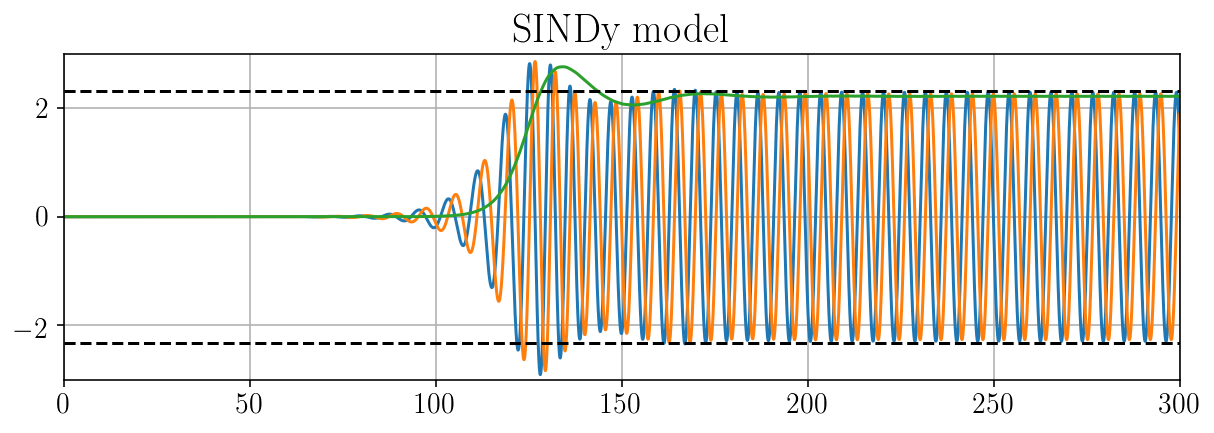

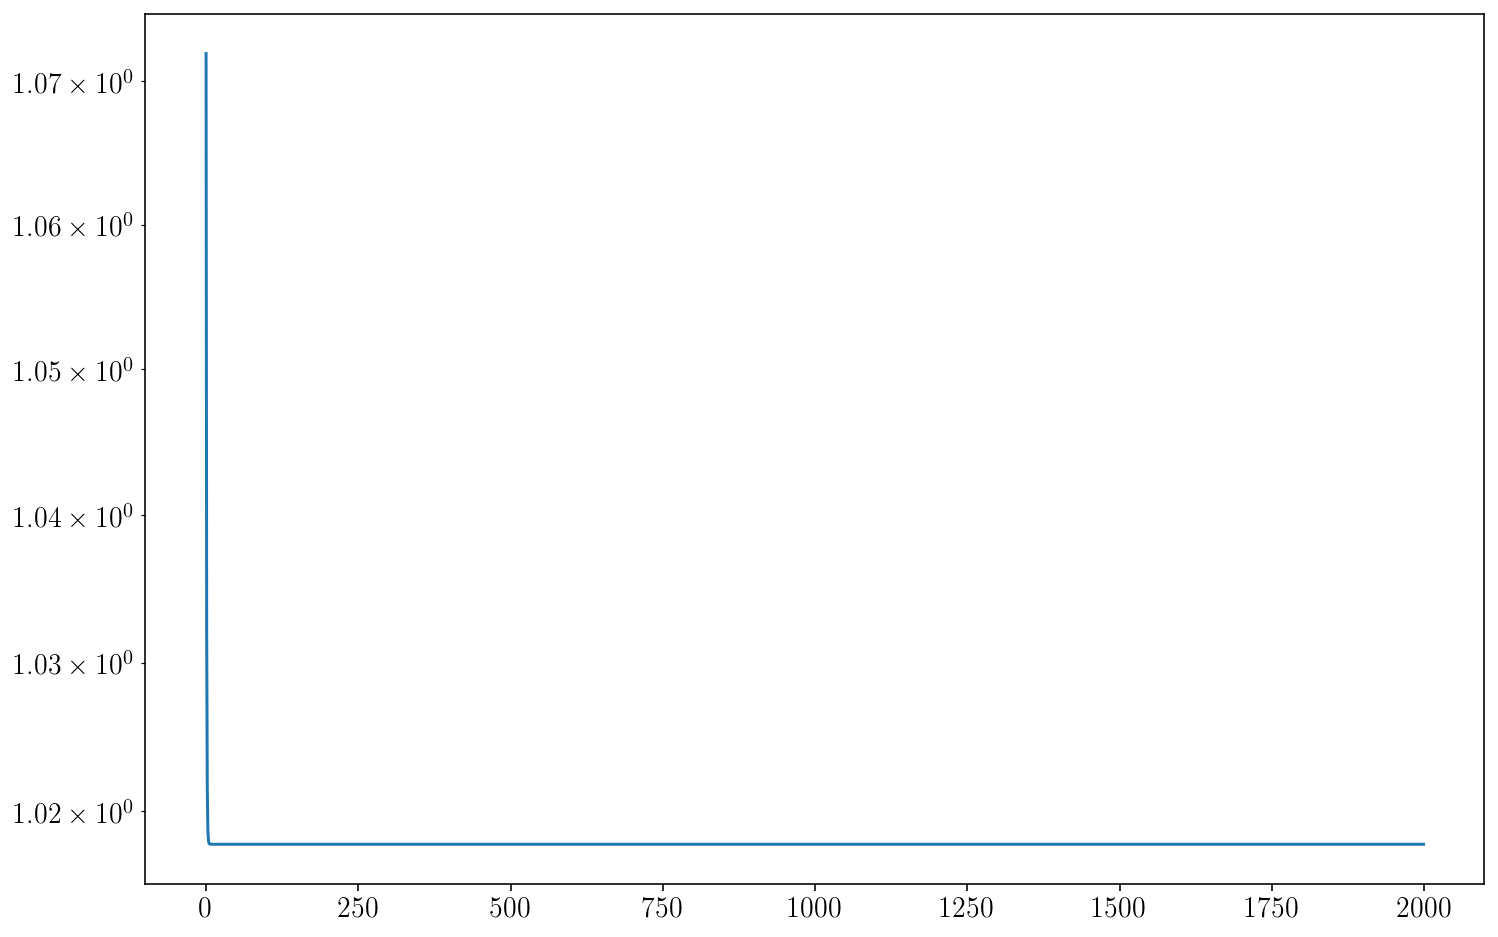

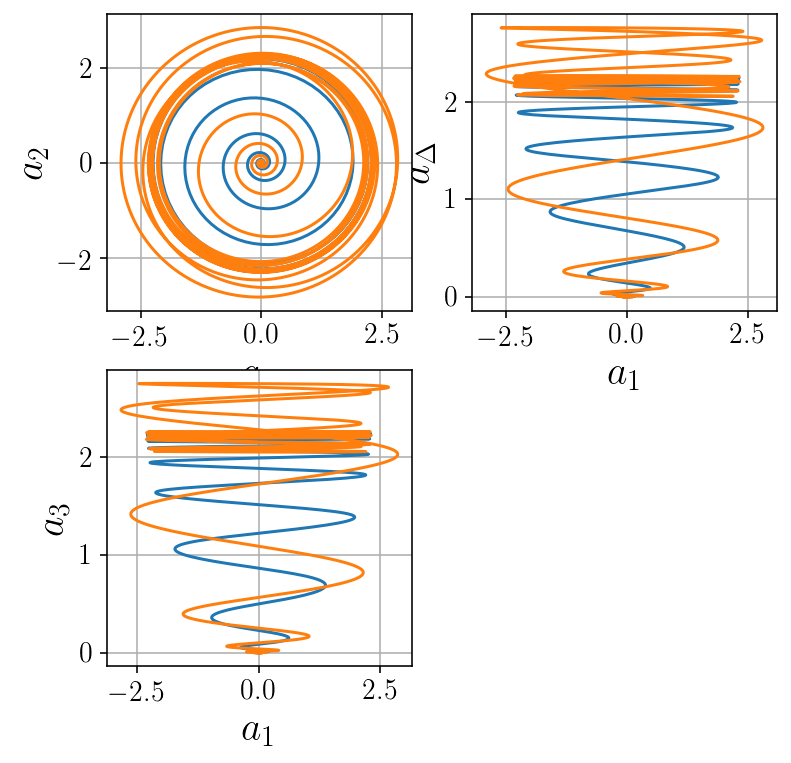

In [7]:
eta = 1.0e4
sindy_opt = ps.proxgradSR3(threshold=threshold, nu=nu, eta=eta,
                            PL=PL_tensor, PQ=PQ_tensor, max_iter=2000, tol=1e-10,
                            thresholder="l0", eigmin=-1e20, eigmax=-1, 
                            alpha=0.5*min(nu,eta), beta=0.5,
                            constraint_lhs=constraint_matrix,
                            constraint_rhs=constraint_zeros,
                            constraint_order="feature")
model = ps.SINDy(
            optimizer=sindy_opt,
            feature_library=sindy_library,
            differentiation_method=ps.FiniteDifference(drop_endpoints=True))
model.fit(a3, t=t)
model.print()
Xi = model.coefficients().T
print(Xi)
opt_m = sindy_opt.m_history_[-1]
mPQ = np.zeros(PL_tensor.shape)
for i in range(r):
    for j in range(i+1, r):
        for k in range(r):
            mPQ[i, j, k, int((i+1)/2.0*(2*r-i)) + j - 1 - i] = opt_m[k] #* PQ_tensor[i, j, int((i+1)/2.0*(2*r-i)) + j - 1 - i]
for i in range(r):
    for k in range(r):
        mPQ[i, i, k, Nr - r + i] = opt_m[k] #*PQ_tensor[i, i, Nr - r + i]
for i in range(r):
    for j in range(Nr):
        mPQ[:, :, i, j] = 0.5 * (mPQ[:, :, i, j] + mPQ[:, :, i, j].T)     
P_tensor = PL_tensor - mPQ
As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
        #print('As: ', As)
eigvals, eigvecs = np.linalg.eig(As)
print(opt_m)
print('As eigvals: ', eigvals)
print(np.all(eigvals < 0))
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-20
integrator_keywords['h0'] = 1e-5
a_sindy3 = model.simulate(a3[300,:], t_sim, integrator_kws=integrator_keywords)

plt.figure(figsize=(10, 3))
plt.plot(t_sim, a_sindy3[:, [0, 1, -1]])
plt.plot([t_sim[0], t_sim[-1]], [a_max, a_max], 'k--')
plt.plot([t_sim[0], t_sim[-1]], [-a_max, -a_max], 'k--')
plt.ylim([-3, 3])
plt.xlim([0, 300])
plt.title('SINDy model')
plt.grid()
plt.figure()
plt.semilogy(sindy_opt.objective_history)

plt.figure(figsize=(6, 6))
plt.subplot(221)
plt.plot(a[:, 0], a[:, 1])
plt.plot(a_sindy3[:, 0], a_sindy3[:, 1])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_2$')
plt.grid()

plt.subplot(222)
plt.plot(a[:, 0], a[:, -1])
plt.plot(a_sindy3[:, 0], a_sindy3[:, -1])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_\Delta$')
plt.grid()

plt.subplot(223)
plt.plot(a[:, 1], a[:, -1])
plt.plot(a_sindy3[:, 1], a_sindy3[:, -1])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_3$')
plt.grid()

# plt.subplot(224)
# plt.plot(a[:, 0], a[:, 4])
# plt.plot(a_sindy3[:, 0], a_sindy3[:, 4])
# plt.xlabel(r'$a_1$')
# plt.ylabel(r'$a_5$')
# plt.grid()
plt.show()

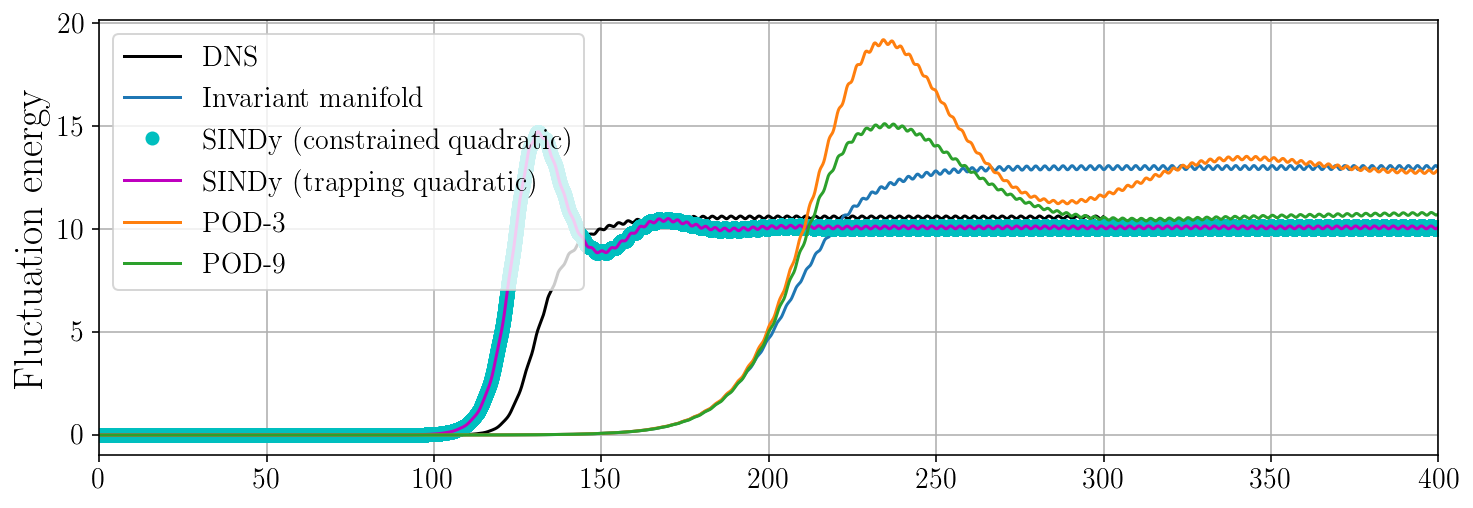

In [8]:
# Energy plots

# Energy of the models
E = np.sum(a**2, axis=1)
E_galerkin3 = np.sum(a_galerkin3**2, axis=1)
E_galerkin9 = np.sum(a_galerkin9**2, axis=1)
E_manifold = np.sum(a_manifold**2, axis=0)
E_sindy = np.sum(a_sindy**2, axis=1)
E_sindy2 = np.sum(a_sindy2**2, axis=1)
E_sindy3 = np.sum(a_sindy3**2, axis=1)

plt.figure(figsize=(12, 4))
plt.plot(t, E, 'k', label='DNS')
plt.plot(t_sim, E_manifold, label='Invariant manifold')
#plt.plot(t_sim, E_quadratic, label='Quadratic')
#plt.plot(t_sim, E_cubic, label='Cubic')
#plt.plot(t_sim, E_sindy, label=r'SINDy (cubic)')
plt.plot(t_sim, E_sindy2, 'co', label=r'SINDy (constrained quadratic)')
plt.plot(t_sim, E_sindy3, 'm', label=r'SINDy (trapping quadratic)')
plt.plot(t_sim, E_galerkin3, label='POD-3')
plt.plot(t_sim, E_galerkin9, label='POD-9')

plt.legend(fontsize=14, loc=2)
plt.grid()
#plt.gca().set_yscale('log')
plt.xlim([0, 400])
plt.ylabel('Fluctuation energy')
#plt.gca().set_yscale('log')
#plt.ylim([1e-8, 1e3])
plt.show()

### Retry constrained SINDy with 9-mode model with no thresholding

/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/constrained_sr3.py:301: ConvergenceWarning: SR3._reduce did not converge after 20000 iterations.
  ConvergenceWarning,


x0' = 0.100 x0 + -0.819 x1 + 0.018 x2 + 0.014 x3 + -0.432 x4 + 0.157 x5 + -0.029 x6 + 0.008 x7 + -0.002 x8 + 0.002 x0x1 + -0.124 x0x2 + -0.092 x0x3 + -0.008 x0x4 + -0.001 x0x5 + 0.026 x0x6 + -0.039 x0x7 + -0.032 x0x8 + -0.048 x1x2 + 0.052 x1x3 + -0.004 x1x4 + 0.006 x1x5 + 0.052 x1x6 + 0.026 x1x7 + -0.166 x1x8 + 0.001 x2x3 + 0.561 x2x4 + -0.045 x2x5 + 0.008 x2x6 + 0.048 x2x7 + -0.003 x2x8 + 0.017 x3x4 + 0.579 x3x5 + 0.009 x3x6 + 0.024 x3x7 + -0.003 x3x8 + 0.002 x4x5 + -0.876 x4x6 + -0.961 x4x7 + 0.134 x4x8 + -0.936 x5x6 + 0.873 x5x7 + -0.081 x5x8 + 0.039 x6x7 + 0.012 x6x8 + -0.007 x7x8 + 0.001 x1x1 + -0.031 x2x2 + -0.014 x3x3 + 0.020 x4x4 + -0.008 x5x5 + -0.023 x6x6 + -0.011 x7x7
x1' = 0.818 x0 + 0.126 x1 + -0.001 x2 + -0.006 x3 + 0.213 x4 + 0.544 x5 + 0.014 x6 + -0.008 x7 + 0.004 x8 + -0.001 x0x1 + -0.102 x0x2 + -0.036 x0x3 + -0.005 x0x4 + 0.003 x0x5 + 0.104 x0x6 + -0.002 x0x7 + 0.130 x0x8 + -0.129 x1x2 + 0.062 x1x3 + -0.001 x1x4 + 0.003 x1x5 + 0.026 x1x6 + 0.125 x1x7 + -0.068 x1x8 + -

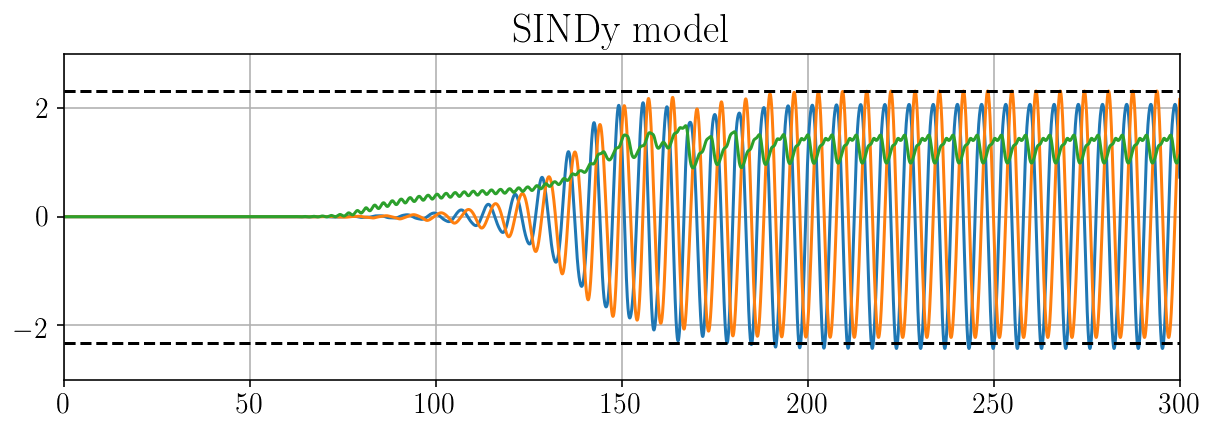

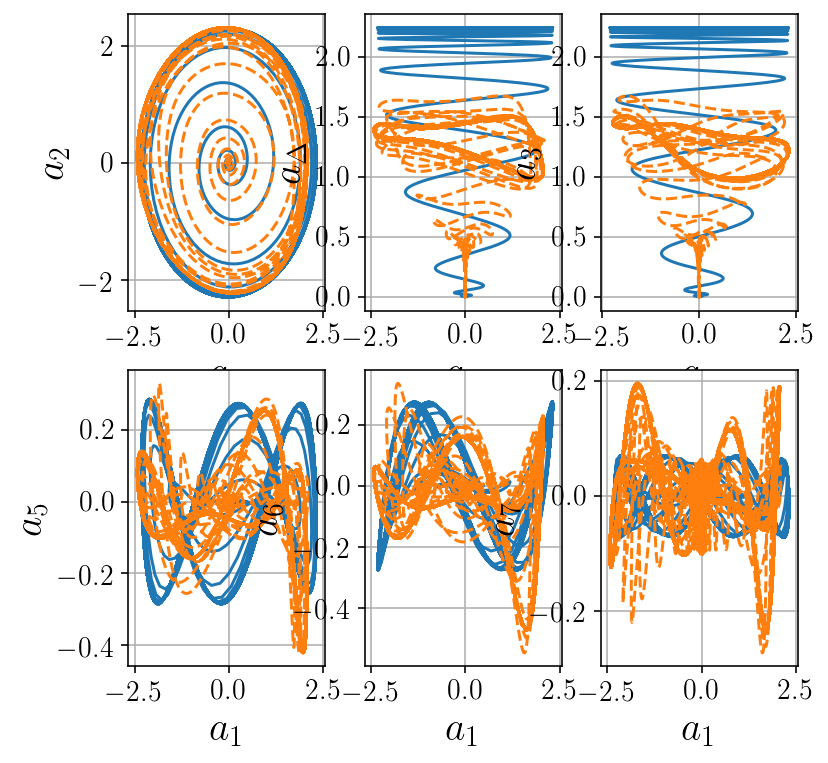

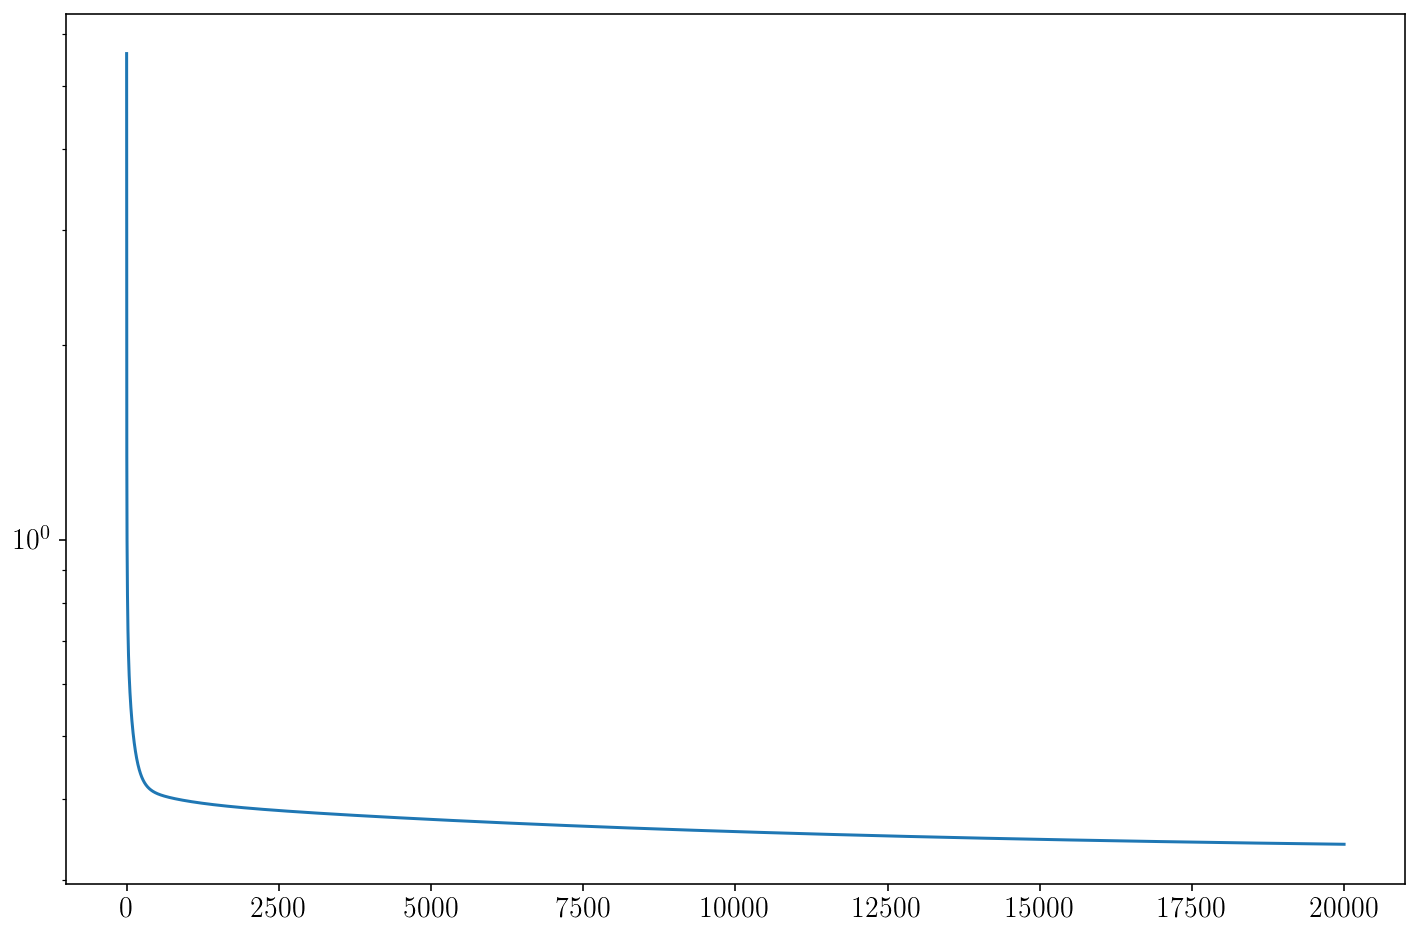

In [9]:
# Nonlinear correlations for POD reconstruction
steady_idx = t>250

## Setup hyperparameters and matrices
r = 9
Nr = int((r**2 + 3*r)/2.0)
q = 0
constraint_zeros = np.zeros((r + r*(r-1) + int(r*(r-1)*(r-2)/6.0)))
constraint_matrix = np.zeros((r + r*(r-1) + int(r*(r-1)*(r-2)/6.0), r * Nr))

# Set coefficients adorning terms like a_i^3 to zero
for i in range(r):
    constraint_matrix[q, r*(int((r**2+3*r)/2.0)-r) + i*(r+1)] = 1.0
    q = q + 1

# Set coefficients adorning terms like a_ia_j^2 to be antisymmetric
for i in range(r):
    for j in range(i+1, r):
        constraint_matrix[q, r*(int((r**2+3*r)/2.0)-r+j)+i] = 1.0
        constraint_matrix[q, r*(r+j-1)+j+r*int(i*(2*r-i-3)/2.0)] = 1.0
        q = q + 1
for i in range(r):
     for j in range(0, i):
        constraint_matrix[q, r*(int((r**2+3*r)/2.0)-r+j)+i] = 1.0
        constraint_matrix[q, r*(r+i-1)+j+r*int(j*(2*r-j-3)/2.0)] = 1.0
        q = q + 1

# Set coefficients adorning terms like a_ia_ja_k to be antisymmetric
for i in range(r):
    for j in range(i+1, r):
        for k in range(j+1, r):
            constraint_matrix[q, r*(r+k-1)+i+r*int(j*(2*r-j-3)/2.0)] = 1.0
            constraint_matrix[q, r*(r+k-1)+j+r*int(i*(2*r-i-3)/2.0)] = 1.0
            constraint_matrix[q, r*(r+j-1)+k+r*int(i*(2*r-i-3)/2.0)] = 1.0
            q = q + 1
# delta_{il}delta_{jk}
PL_tensor = np.zeros((r, r, r, Nr))
for i in range(r):
    for j in range(r):
        for k in range(r):
            for l in range(Nr):
                if i == l and j == k:
                    PL_tensor[i, j, k, l] = 1.0

# Now symmetrize PL
for i in range(r):
    for j in range(Nr):
        PL_tensor[:, :, i, j] = 0.5 * (PL_tensor[:, :, i, j] + PL_tensor[:, :, i, j].T)

PQ_tensor = np.zeros((r, r, Nr))
for i in range(r):
    # Off diagonal terms
    for j in range(i+1, r):
        PQ_tensor[i, j, int((i+1)/2.0*(2*r-i)) + j - 1 - i] = 1.0

    # diagonal terms
    PQ_tensor[i, i, Nr - r + i] = 1.0

# Now symmetrize PQ
for j in range(Nr):
    PQ_tensor[:, :, j] = 0.5 * (PQ_tensor[:, :, j] + PQ_tensor[:, :, j].T)
    
    
threshold = 0.0
poly_order = 2
library_functions = [lambda x:x, lambda x, y:x*y, lambda x:x**2]
#                     lambda x, y, z:x*y*z, lambda x, y:x**2*y, lambda x:x**3]
library_function_names = [lambda x:x, lambda x, y:x+y, lambda x:x+x]
#                          lambda x, y, z:x+y+z, lambda x, y:x+y, lambda x:x+x+x]
sindy_library = ps.CustomLibrary(library_functions=library_functions,
                                 function_names=library_function_names)

nu = 1.0
sindy_opt = ps.ConstrainedSR3(threshold=threshold, nu=nu,
                              max_iter=20000, tol=1e-5,
                              thresholder="l0",
                              constraint_lhs=constraint_matrix,
                              constraint_rhs=constraint_zeros,
                              constraint_order="feature")
model = ps.SINDy(
            optimizer=sindy_opt,
            feature_library=sindy_library,
            differentiation_method=ps.FiniteDifference(drop_endpoints=True))
model.fit(a[:, :r], t=t)
model.print()
Xi = model.coefficients().T
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-20
integrator_keywords['h0'] = 1e-5
a_sindy2 = model.simulate(a[300,:r], t_sim, integrator_kws=integrator_keywords)

plt.figure(figsize=(10, 3))
plt.plot(t_sim, a_sindy2[:, [0, 1, -1]])
plt.plot([t_sim[0], t_sim[-1]], [a_max, a_max], 'k--')
plt.plot([t_sim[0], t_sim[-1]], [-a_max, -a_max], 'k--')
plt.ylim([-3, 3])
plt.xlim([0, 300])
plt.title('SINDy model')
plt.grid()

plt.figure(figsize=(6, 6))
plt.subplot(231)
plt.plot(a[:, 0], a[:, 1])
plt.plot(a_sindy2[:, 0], a_sindy2[:, 1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_2$')
plt.grid()

plt.subplot(232)
plt.plot(a[:, 0], a[:, -1])
plt.plot(a_sindy2[:, 0], a_sindy2[:, -1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_\Delta$')
plt.grid()

plt.subplot(233)
plt.plot(a[:, 1], a[:, -1])
plt.plot(a_sindy2[:, 1], a_sindy2[:, -1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_3$')
plt.grid()

plt.subplot(234)
plt.plot(a[:, 0], a[:, 4])
plt.plot(a_sindy2[:, 0], a_sindy2[:, 4],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_5$')
plt.grid()

plt.subplot(235)
plt.plot(a[:, 0], a[:, 5])
plt.plot(a_sindy2[:, 0], a_sindy2[:, 5],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_6$')
plt.grid()

plt.subplot(236)
plt.plot(a[:, 0], a[:, 6])
plt.plot(a_sindy2[:, 0], a_sindy2[:, 6],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_7$')
plt.grid()

plt.figure()
plt.semilogy(sindy_opt.objective_history)
plt.show()

### Take constrained SINDy model and search for an optimal m with simulated annealing
This is a check to see if the constrained SINDy model is stable even without the extra minimizations that our new SINDy algorithm uses. Looks like it is (although this minimization is kind of shady... why does As have imaginary eigenvalues ... wouldn't that imply the energy has an imaginary piece) but we still can probably improve this, especially because this minimization over m doesn't use any of the gradient info. 

In [10]:
from scipy.optimize import dual_annealing

# Get model L and Q 
Ls = np.tensordot(PL_tensor, Xi, axes=([3,2],[0,1]))
Q = np.tensordot(PQ_tensor, Xi, axes=([2],[0]))

def obj_function(m, L_obj, Q_obj):
    As = np.zeros(L_obj.shape)
    for i in range(r):
        As[i, :] = L_obj[i, :] - np.dot(m, Q_obj[:, i, :])
    eigvals, eigvecs = np.linalg.eig(As)
    return(np.sort(eigvals)[-1].real)

boundvals = np.zeros((r, 2))
boundmax = 100
boundmin = -100
boundvals[:, 0] = boundmin
boundvals[:, 1] = boundmax

algo_sol = dual_annealing(obj_function, bounds=boundvals, args=(Ls, Q), maxiter=2000)
opt_m = algo_sol.x
opt_energy = algo_sol.fun
opt_result = algo_sol.message
print(opt_m, opt_energy, opt_result)
A_identified = L - np.tensordot(opt_m, Q, axes=([0, 0]))
print(A_identified)
eigvals, eigvecs = np.linalg.eig(A_identified)
print(np.sort(eigvals), np.all(eigvals < 0.0))

[ 15.04591863  12.89935032  71.90938107 -92.22833535  44.98940481
  64.8320507   44.31775589 -58.45735485  94.82159037] -35.05726726118694 ['Maximum number of iteration reached']
[[ 2.44135538e-01 -7.46042063e+00  2.23415897e+01  1.32225132e+01
   3.99710806e+00 -3.92279316e+01 -1.16861674e+01  2.28763057e+01
   6.13667152e-02]
 [ 1.23717469e+01  1.37694161e+01 -2.23766083e+01  2.59955019e+01
   2.13011008e+01  5.61651168e+01  2.39435282e+01  2.87534817e+01
  -9.44622937e+00]
 [-6.25402550e+00  2.10972805e+01  4.31488607e+01 -3.64356424e+01
   6.26076317e+00 -1.46407653e+01 -3.97013696e+02  3.34576118e+01
   5.04331371e+01]
 [-1.94688744e+01 -6.51290423e+00 -5.17908453e+01 -1.02971217e+02
  -4.55155405e+00 -1.17800155e+01  4.92243578e+01  9.66314827e+01
   1.20377747e+01]
 [-3.52935617e+01  3.49076529e+01  6.18211182e+00  8.50995511e+00
  -9.01874902e+01  7.30815257e+01 -2.30488058e+01  5.01387978e+00
   8.42601639e+01]
 [ 7.87966638e+01 -1.60940406e+01  3.56899164e+00  9.24450783e+00


### Retry new constrained SINDy with 9-mode model with no threshold

/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 10000 iterations.
  ConvergenceWarning,


x0' = 0.100 x0 + -0.816 x1 + 0.017 x2 + 0.010 x3 + -0.424 x4 + 0.148 x5 + -0.023 x6 + 0.005 x7 + -0.002 x8 + 0.001 x0x1 + -0.121 x0x2 + -0.084 x0x3 + -0.008 x0x4 + 0.031 x0x6 + 0.006 x0x7 + -0.032 x0x8 + -0.051 x1x2 + 0.059 x1x3 + -0.003 x1x4 + 0.005 x1x5 + 0.008 x1x6 + 0.031 x1x7 + -0.166 x1x8 + -0.003 x2x3 + 0.506 x2x4 + -0.136 x2x5 + 0.007 x2x6 + 0.044 x2x7 + -0.005 x2x8 + 0.107 x3x4 + 0.523 x3x5 + -0.001 x3x6 + 0.012 x3x7 + -0.001 x3x8 + -0.638 x4x6 + -1.145 x4x7 + 0.145 x4x8 + -1.125 x5x6 + 0.633 x5x7 + -0.080 x5x8 + 0.032 x6x7 + 0.009 x6x8 + -0.006 x7x8 + 0.001 x1x1 + -0.026 x2x2 + -0.008 x3x3 + 0.018 x4x4 + -0.006 x5x5 + -0.017 x6x6 + -0.017 x7x7
x1' = 0.814 x0 + 0.125 x1 + -0.004 x2 + -0.005 x3 + 0.209 x4 + 0.528 x5 + 0.012 x6 + -0.008 x7 + 0.003 x8 + -0.001 x0x1 + -0.074 x0x2 + -0.045 x0x3 + -0.005 x0x4 + 0.002 x0x5 + 0.070 x0x6 + 0.005 x0x7 + 0.127 x0x8 + -0.130 x1x2 + 0.045 x1x3 + -0.002 x1x4 + 0.003 x1x5 + 0.013 x1x6 + 0.089 x1x7 + -0.067 x1x8 + -0.014 x2x3 + -0.256 x2x4 + 

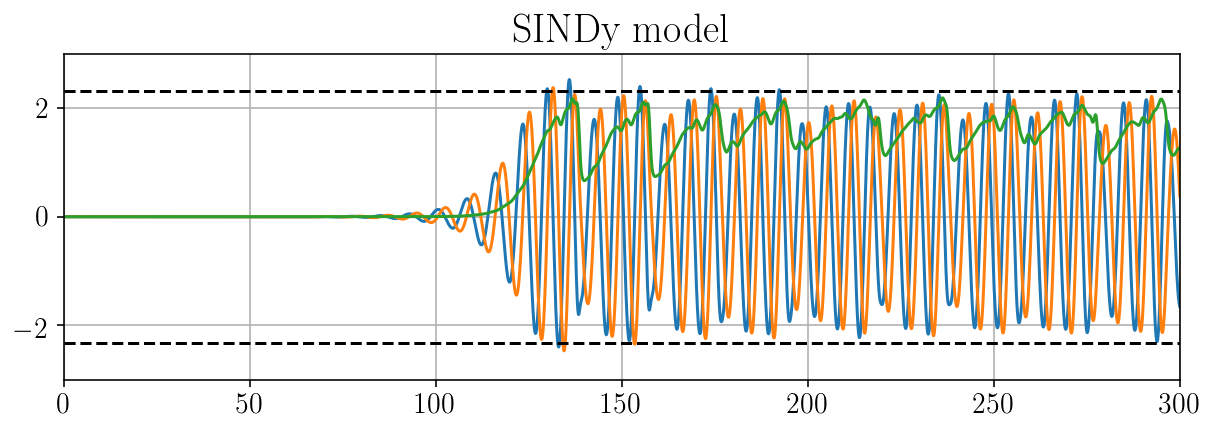

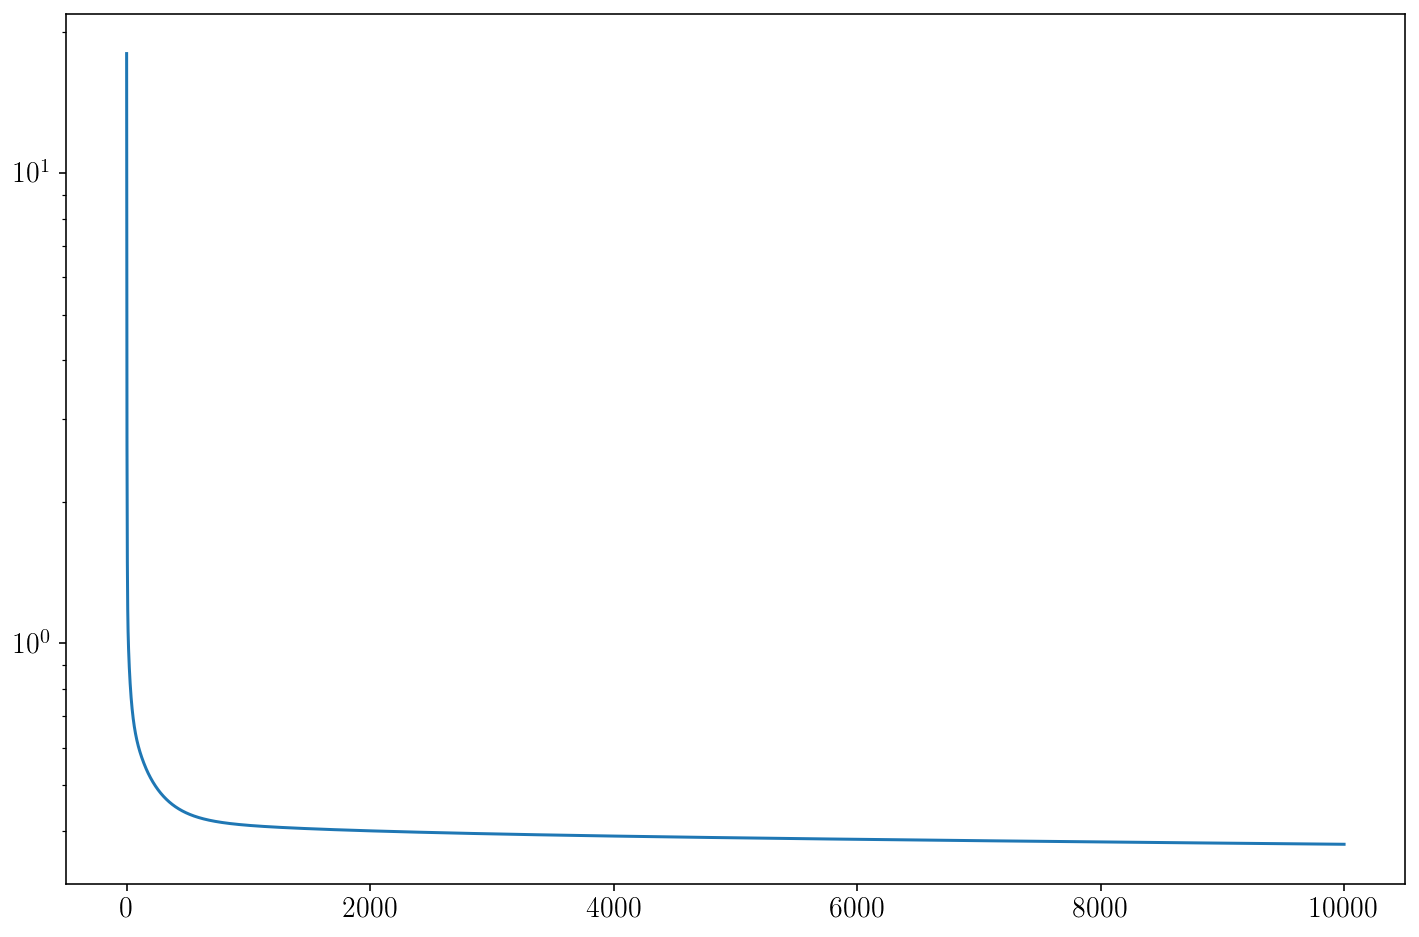

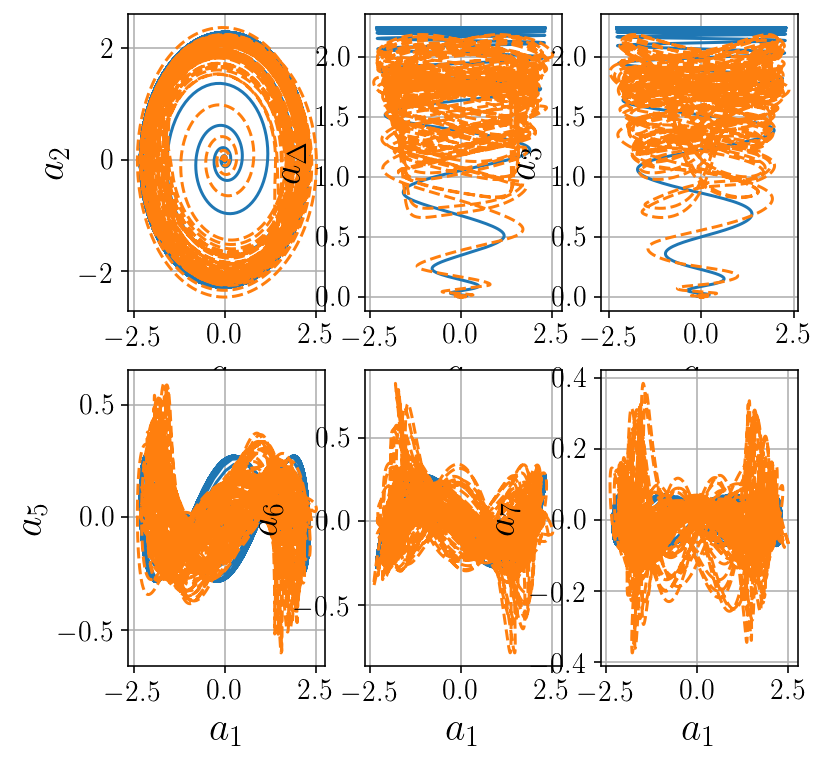

In [11]:
## Reproduces constrained sindy when eta is very large
eta = 1e3
sindy_opt = ps.proxgradSR3(threshold=threshold, nu=nu, eta=eta,
                            PL=PL_tensor, PQ=PQ_tensor, max_iter=10000, tol=1e-10,
                            thresholder="l0", eigmin=-1e20, eigmax=-1, 
                            alpha=0.5*min(nu,eta), beta=0.5*eta,
                            constraint_lhs=constraint_matrix,
                            constraint_rhs=constraint_zeros,
                            constraint_order="feature")
model = ps.SINDy(
            optimizer=sindy_opt,
            feature_library=sindy_library,
            differentiation_method=ps.FiniteDifference(drop_endpoints=True))
model.fit(a[:, :r], t=t)
model.print()
Xi = model.coefficients().T
opt_m = sindy_opt.m_history_[-1]
mPQ = np.zeros(PL_tensor.shape)
for i in range(r):
    for j in range(i+1, r):
        mPQ[i, j, :, int((i+1)/2.0*(2*r-i)) + j - 1 - i] = opt_m
for i in range(r):
    mPQ[i, i, :, Nr - r + i] = opt_m
for i in range(r):
    for j in range(Nr):
        mPQ[:, :, i, j] = 0.5 * (mPQ[:, :, i, j] + mPQ[:, :, i, j].T)     
P_tensor = PL_tensor - mPQ
As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
        #print('As: ', As)
eigvals, eigvecs = np.linalg.eig(As)
print(opt_m)
print('As eigvals: ', eigvals)
print(np.all(eigvals < 0))
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-20
integrator_keywords['h0'] = 1e-5
a_sindy3 = model.simulate(a[300,:r], t_sim, integrator_kws=integrator_keywords)

plt.figure(figsize=(10, 3))
plt.plot(t_sim, a_sindy3[:, [0, 1, -1]])
plt.plot([t_sim[0], t_sim[-1]], [a_max, a_max], 'k--')
plt.plot([t_sim[0], t_sim[-1]], [-a_max, -a_max], 'k--')
plt.ylim([-3, 3])
plt.xlim([0, 300])
plt.title('SINDy model')
plt.grid()
plt.figure()
plt.semilogy(sindy_opt.objective_history)

plt.figure(figsize=(6, 6))
plt.subplot(231)
plt.plot(a[:, 0], a[:, 1])
plt.plot(a_sindy3[:, 0], a_sindy3[:, 1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_2$')
plt.grid()

plt.subplot(232)
plt.plot(a[:, 0], a[:, -1])
plt.plot(a_sindy3[:, 0], a_sindy3[:, -1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_\Delta$')
plt.grid()

plt.subplot(233)
plt.plot(a[:, 1], a[:, -1])
plt.plot(a_sindy3[:, 1], a_sindy3[:, -1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_3$')
plt.grid()

plt.subplot(234)
plt.plot(a[:, 0], a[:, 4])
plt.plot(a_sindy3[:, 0], a_sindy3[:, 4],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_5$')
plt.grid()

plt.subplot(235)
plt.plot(a[:, 0], a[:, 5])
plt.plot(a_sindy3[:, 0], a_sindy3[:, 5],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_6$')
plt.grid()

plt.subplot(236)
plt.plot(a[:, 0], a[:, 6])
plt.plot(a_sindy3[:, 0], a_sindy3[:, 6],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_7$')
plt.grid()
plt.show()

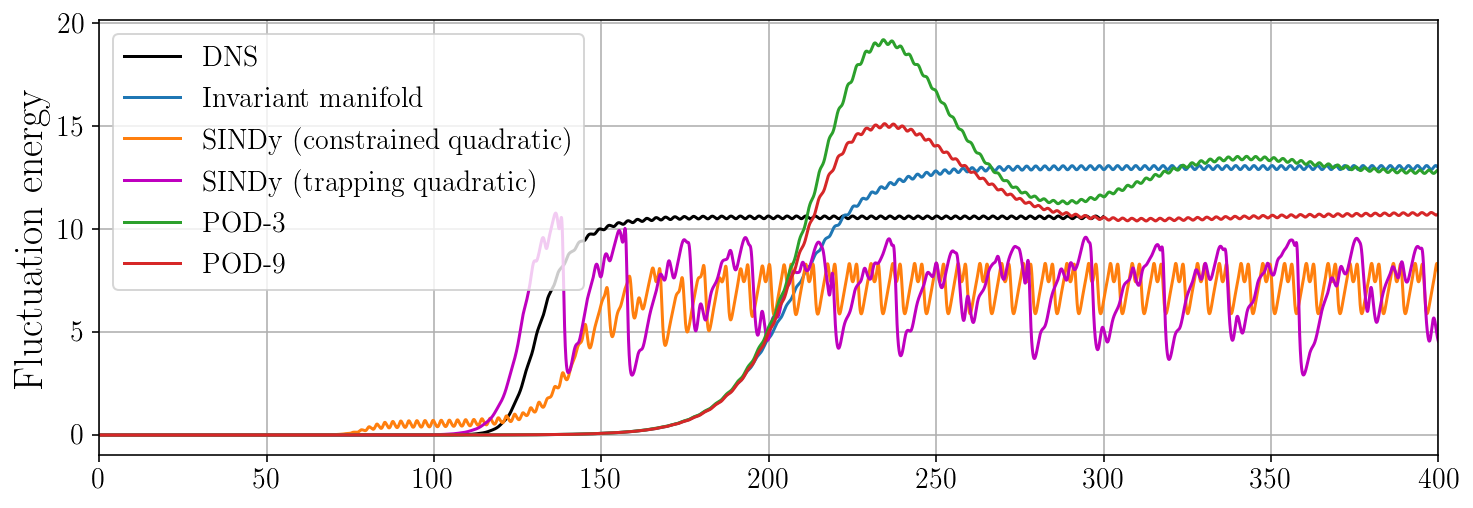

In [12]:
# Energy plots

# Energy of the models
E = np.sum(a**2, axis=1)
E_galerkin3 = np.sum(a_galerkin3**2, axis=1)
E_galerkin9 = np.sum(a_galerkin9**2, axis=1)
E_manifold = np.sum(a_manifold**2, axis=0)
E_sindy = np.sum(a_sindy**2, axis=1)
E_sindy2 = np.sum(a_sindy2**2, axis=1)
E_sindy3 = np.sum(a_sindy3**2, axis=1)

plt.figure(figsize=(12, 4))
plt.plot(t, E, 'k', label='DNS')
plt.plot(t_sim, E_manifold, label='Invariant manifold')
#plt.plot(t_sim, E_quadratic, label='Quadratic')
#plt.plot(t_sim, E_cubic, label='Cubic')
#plt.plot(t_sim, E_sindy, label=r'SINDy (cubic)')
plt.plot(t_sim, E_sindy2, label=r'SINDy (constrained quadratic)')
plt.plot(t_sim, E_sindy3, 'm', label=r'SINDy (trapping quadratic)')
plt.plot(t_sim, E_galerkin3, label='POD-3')
plt.plot(t_sim, E_galerkin9, label='POD-9')

plt.legend(fontsize=14, loc=2)
plt.grid()
#plt.gca().set_yscale('log')
plt.xlim([0, 400])
plt.ylabel('Fluctuation energy')
#plt.gca().set_yscale('log')
#plt.ylim([1e-8, 1e3])
plt.show()

### Repeat the model space analysis in example 8
Doing this to figure out where in the $(\eta,\gamma)$ space ($\lambda = 0$) we might expect improvements with the new algorithm

In [15]:
# Scan the (eta, gamma) model space -- depending on max_iter, this can take a long time
Neta = 20
Neig = 20
eta_scan = np.logspace(-1, 10, Neta)
eigmax_scan = np.logspace(-2, 3, Neig)
A_scan = np.zeros((r, Neta, Neig))
Xdot_contours = np.zeros((Neta, Neig))
objectives = []
m_scan = []
X = []
Xdot = []
Xis = []

x_test = a[300:, :r]
x_t = a[:, :r]
x_dot = model.differentiate(x_t, t=t)
    
for i in range(Neta):
    print(i)
    for j in range(Neig):
        
        sindy_opt = ps.proxgradSR3(threshold=threshold, nu=nu, eta=eta_scan[i],
                                  PL=PL_tensor, PQ=PQ_tensor, max_iter=200, tol=1e-5,
                                  thresholder="l0", eigmin=-(10**20), eigmax=-eigmax_scan[j],
                                  alpha=0.5*min(eta_scan[i], nu),beta=0.5*eta_scan[i], 
                                  constraint_lhs=constraint_matrix,
                                  constraint_rhs=constraint_zeros,
                                  constraint_order="feature")

        model = ps.SINDy(
            optimizer=sindy_opt,
            feature_library=sindy_library,
            differentiation_method=ps.FiniteDifference(drop_endpoints=True),
        )
        
        model.fit(x_t, t=t)
        opt_m = sindy_opt.m_history_[-1]
        Xi = model.coefficients().T
        mPQ = np.zeros(PL_tensor.shape)
        for ii in range(r):
            for jj in range(ii+1, r):
                mPQ[ii, jj, :, int((ii+1)/2.0*(2*r-ii)) + jj - 1 - ii] = opt_m
        for ii in range(r):
            mPQ[ii, ii, :, Nr - r + ii] = opt_m

        for ii in range(r):
            for jj in range(Nr):
                mPQ[:, :, ii, jj] = 0.5 * (mPQ[:, :, ii, jj] + mPQ[:, :, ii, jj].T)    
        P_tensor = PL_tensor - mPQ
        As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
        eigvals, eigvecs = np.linalg.eig(As)
        A_scan[:, i, j] = eigvals
        m_scan.append(opt_m)
        x_dot_pred = model.predict(x_t)
        Xdot_contours[i, j] = np.linalg.norm(x_dot[1:-1,:] - x_dot_pred[1:-1,:])
        x_pred = model.simulate(a[300,:], t[300:], integrator_kws=integrator_keywords)
        Xdot.append(x_dot_pred)
        X.append(x_pred)
        Xis.append(Xi)
        objectives.append(sindy_opt.objective_history)

0


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantita

1


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:36

2


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:36

3


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:36

4


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:36

5


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:36

6


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:36

7


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:36

8


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:36

9


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:36

10


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:36

11


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:36

12


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:36

13


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:36

14


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:36

15


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:36

16


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:36

17


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:36

18


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:36

19


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:366: ConvergenceWarning: proxgradSR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:36

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply


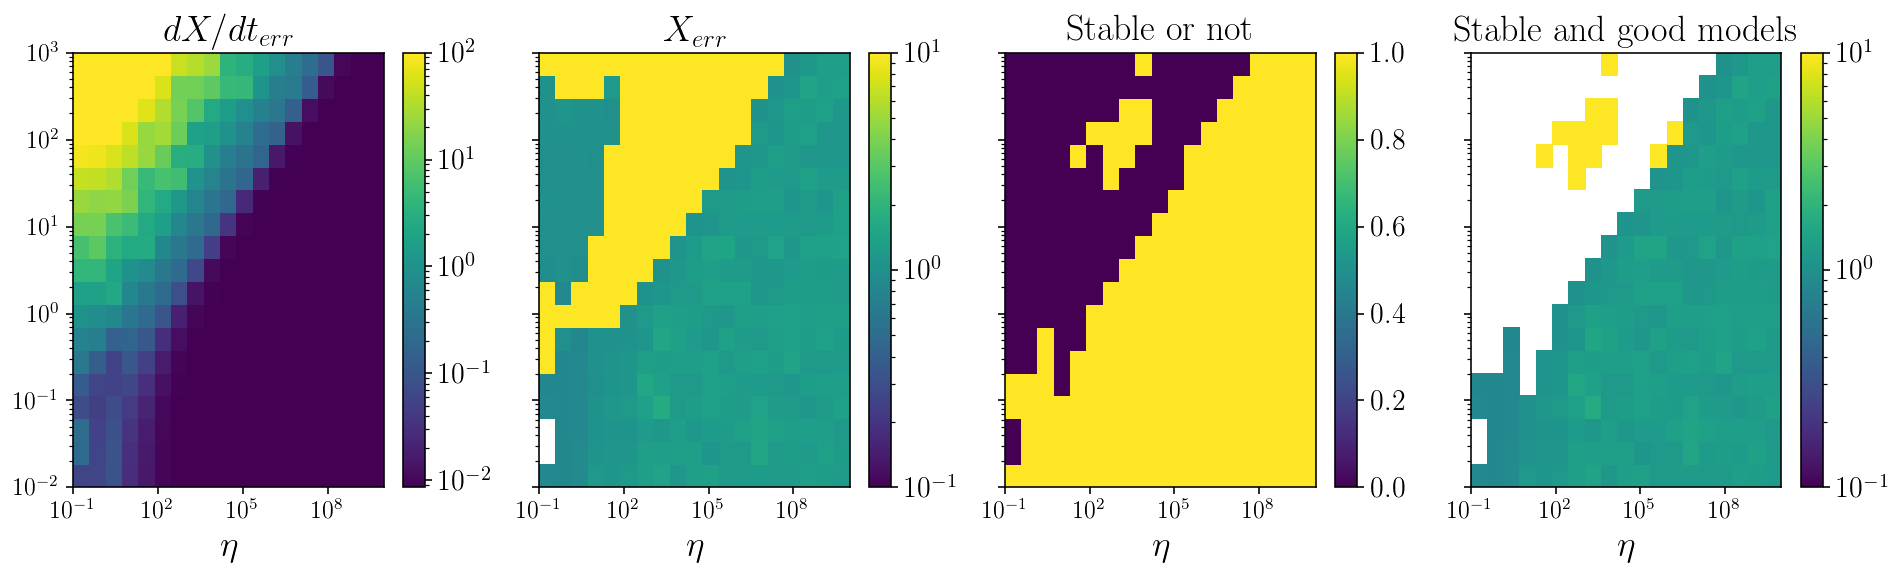

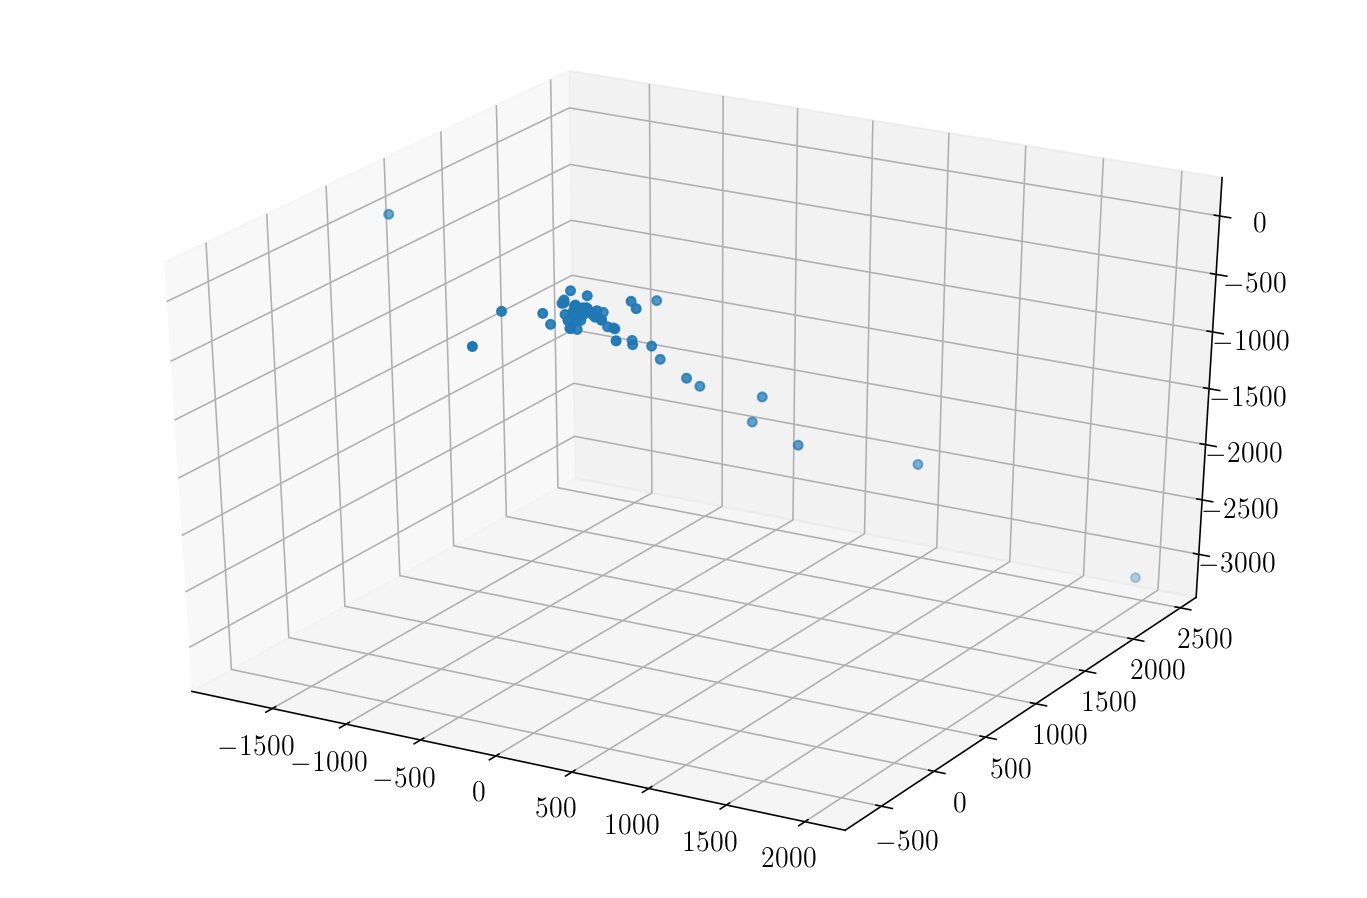

In [26]:
from matplotlib.colors import LogNorm
x_dot = model.differentiate(x_t, t=t)
Xdot = np.asarray(Xdot)
X = np.asarray(X)
Xdot_err = np.zeros((Neta, Neig))
X_err = np.zeros((Neta, Neig))
x_interp = x_test #np.zeros((len(t_sim),r))
#for i in range(r):
# x_interp[:, i] = np.interp(t_sim, t[300:], x_test[:, i])
for i in range(Neta):
    for j in range(Neig):
        Xdot_err[i,j] = np.linalg.norm(Xdot[i*Neig+j, 1:-1, :] - x_dot[1:-1,:])/np.linalg.norm(x_dot[1:-1,:])
        X_err[i,j] = np.linalg.norm(X[i*Neig+j, 1:-1, :] - x_interp[1:-1,:])/np.linalg.norm(x_interp[1:-1,:])
fs = 18
ts = 12
eta, lam = np.meshgrid(eta_scan, eigmax_scan, indexing='ij')
plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
plt.pcolor(eta, lam, Xdot_err,norm=LogNorm(vmin=Xdot_err.min(), vmax=1e2))
plt.xlabel(r'$\eta$',fontsize=fs)
plt.title(r'$dX/dt_{err}$',fontsize=fs)
plt.colorbar()
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(axis='x', labelsize=ts)
ax.tick_params(axis='y', labelsize=ts)
#ax.set_yticklabels([])
plt.subplot(1,4,2)
plt.pcolor(eta, lam, X_err, norm=LogNorm(vmin=1e-1, vmax=1e1))
plt.xlabel(r'$\eta$',fontsize=fs)
plt.title(r'$X_{err}$',fontsize=fs)
plt.colorbar()
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(axis='x', labelsize=ts)
ax.tick_params(axis='y', labelsize=ts)
ax.set_yticklabels([])

plt.subplot(1,4,3)
plt.pcolor(eta, lam, np.any(A_scan > 0.0, axis=0))
plt.xlabel(r'$\eta$',fontsize=fs)
plt.title(r'Stable or not',fontsize=fs)
plt.colorbar()
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(axis='x', labelsize=ts)
ax.tick_params(axis='y', labelsize=ts)
ax.set_yticklabels([])

plt.subplot(1,4,4)
plt.pcolor(eta, lam, X_err * np.any(A_scan > 0.0, axis=0),norm=LogNorm(vmin=1e-1, vmax=1e1))
plt.xlabel(r'$\eta$',fontsize=fs)
plt.title(r'Stable and good models',fontsize=fs)
plt.colorbar()
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(axis='x', labelsize=ts)
ax.tick_params(axis='y', labelsize=ts)
ax.set_yticklabels([])
    
m_scan = np.asarray(m_scan)
fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})
ax.scatter(m_scan[:,0], m_scan[:,1], m_scan[:,2],marker='o')